In [1]:
#use wd_models environment

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#put the path the WD_tools and import the module
import sys
import os
sys.path.append('../Software')
import WD_models

plt.style.use('stefan.mplstyle')

# This notebook shows the agreement with the theoretical WD Mass-Radius Relation 
For the photometric sample and the spectroscopic sample

Also for temperature-divided sample

With NO bias corrections

# Import the datasets

In [2]:
SDSSV_eos_tab=pd.read_csv('csv/SDSSV_tempdep_sample.csv')
eSDSS_eos_tab=pd.read_csv('csv/eSDSS_tempdep_sample.csv')
#combined SDSSV/eSDSS table
Eos_tab=pd.read_csv('csv/tempdep_sample.csv')


In [3]:
#import the bin information
r_npzfile = np.load('csv/radius_bins.npz')
r_bins = r_npzfile['bins'] 
r_bin_centers = r_npzfile['centers']
r_bin_ranges = r_npzfile['ranges']
r_bin_nums=r_npzfile['nums']

g_npzfile = np.load('csv/logg_bins.npz')
g_bins = g_npzfile['bins'] 
g_bin_centers = g_npzfile['centers']
g_bin_ranges = g_npzfile['ranges']
g_bin_nums=g_npzfile['nums']

# First, don't divide by temperature

### Take the mean RV of each bin, weighted by the corresponding uncertainties of the measurements, to get the gravitational redshift
https://physics.stackexchange.com/questions/679853/how-to-calculate-the-uncertainty-and-mean-of-multiple-measurements-with-differen
Weighted mean:
$$\bar{x}=\frac{\sum_i \frac{x_i}{\sigma_i^2}}{\sum_i\frac{1}{\sigma_i^2}}$$
Uncertainty on the weighted mean:
$$\sigma=1/\sqrt{\sum_i\frac{1}{\sigma_i^2}}$$
Weights
$$\frac{1}{\sigma_i^2}$$

### Also compute the masses for each bin
The mean RV for each bin has just the gravitational redshift component since the random motion has been averaged-out, mean_RV=$v_g$.

We can use this and the measured mean radius to get the mass via
$$M(R,v_g)=v_gRc/G$$
$$\delta M(R,v_g)=\frac{c}{G}\sqrt{v_g^2\delta R^2+R^2\delta v_g^2}$$
for the photometric radius.

Since $R=\sqrt{GM/g}$, we can use the measured mean Logg to get the mass via
$$M(\log{g},v_g)=v_g^2c^2/Gg=v_g^2c^2/G 10^{\log{g}}$$
$$\delta M(\log{g},v_g)=\frac{v_g c^2}{G 10^{\log{g}}}\sqrt{v_g^2(\ln{10})^2\delta(\log{g})^2+4\delta v_g^2}$$
for the spectroscopic surface gravity.

For completion, (this is how we got individual masses in the previous nb)
$$M(R,\log{g})=gR^2/G=10^{\log{g}}R^2/G$$
$$\delta M(R,\log{g})=\frac{10^{\log{g}}R}{G}\sqrt{4\delta R^2+(R\ln{10})^2\delta(\log{g})^2}$$

In [4]:
MsunCGS=1.989*10**33 #g
RsunCGS=6.955*10**10 #cm
cCGS=2.99792458*10**10 #cm/s
GCGS=6.6743*10**(-8) #cm^3 g^-1 s^-2

def data_m_from_logg_vg(loggs,vgs,e_loggs,e_vgs):
    #compute the spectroscopic mass and error on the mass in solar units
    masses=[]
    e_masses=[]
    #convert vgs from km/s to cm/s (CGS units)
    vgs=vgs*10**(5)
    e_vgs=e_vgs*10**(5)
    #get the surface gravity
    gs=10**(loggs)
    for i in range(len(loggs)):
        M=(((vgs[i]**2)*(cCGS**2))/(GCGS*gs[i]))/MsunCGS
        masses.append(M)
        E_M=(((vgs[i]*(cCGS**2))/(GCGS*gs[i]))*np.sqrt((vgs[i]**2)*((np.log(10))**2)*(e_loggs[i]**2)+4*(e_vgs[i]**2)))/MsunCGS
        e_masses.append(E_M)
    return(masses,e_masses)

def data_m_from_r_vg(radii,vgs,e_radii,e_vgs):
    #compute the photometric mass and error on the mass in solar units
    masses=[]
    e_masses=[]
    #convert vgs from km/s to cm/s (CGS units)
    vgs=vgs*10**(5)
    e_vgs=e_vgs*10**(5)
    #convert radii from solar units to CGS units
    radii=radii*RsunCGS
    e_radii=e_radii*RsunCGS
    for i in range(len(radii)):
        M=(vgs[i]*radii[i]*cCGS/GCGS)/MsunCGS #divide by Msun to get in solar units
        masses.append(M)
        E_M=((cCGS/GCGS)*np.sqrt((vgs[i]**2)*(e_radii[i]**2)+(radii[i]**2)*(e_vgs[i]**2)))/MsunCGS
        e_masses.append(E_M)
    return(masses,e_masses)


In [5]:
def weighted_avg(table,bin_nums,bin_ranges,bin_centers,bin_id_key,x_name,x_key,E_x_key,RV_key,E_RV_key,
                 extra_name=None):
    #calculate the weighted mean radius/logg and uncertainty on the weighted mean radius/logg for each bin
    #calculate the weighted mean RV and uncertainty on the weighted mean RV for each bin
    
    mean_xs=[]
    e_mean_xs=[]
    mean_RVs=[]
    e_mean_RVs=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        x=np.array(tmp[x_key].to_list())
        e_x=np.array(tmp[E_x_key].to_list())
        rv=np.array(tmp[RV_key].to_list())
        e_rv=np.array(tmp[E_RV_key].to_list())
        if len(rv)>0:
            #calculate weights
            x_weights=(1/e_x)**2
            RV_weights=(1/e_rv)**2
            #calculate mean x and error on mean
            mean_x=np.average(x,weights=x_weights)
            e_mean_x=1/np.sqrt(np.sum(x_weights))
            #calculate mean RV and error on mean
            mean_RV=np.average(rv,weights=RV_weights)
            e_mean_RV=1/np.sqrt(np.sum(RV_weights))
        else: #if bin is empty fill with nan values
            mean_x=np.nan
            e_mean_x=np.nan
            mean_RV=np.nan
            e_mean_RV=np.nan
        #record results
        mean_xs.append(mean_x)
        mean_RVs.append(mean_RV)
        e_mean_RVs.append(e_mean_RV)
        e_mean_xs.append(e_mean_x)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)
        
    #get the corresponding masses
    if x_name=='radii':
        masses, e_masses=data_m_from_r_vg(np.array(mean_xs),np.array(mean_RVs),np.array(e_mean_xs),np.array(e_mean_RVs))
    if x_name=='loggs':
        masses, e_masses=data_m_from_logg_vg(np.array(mean_xs),np.array(mean_RVs),np.array(e_mean_xs),np.array(e_mean_RVs))
    
    #convert bin ranges to string
    bin_ranges_str=[]
    for i in range(len(bin_ranges)):
        bin_ranges_str.append(str(bin_ranges[i]))
    
    #save parameters
    final_avg_table=pd.DataFrame()
    final_avg_table[bin_id_key]=bin_nums
    final_avg_table['Bin_range']=bin_ranges_str
    final_avg_table['Bin_center']=bin_centers
    if extra_name==None:
        final_avg_table['mean_'+x_name]=mean_xs
        final_avg_table['e_mean_'+x_name]=e_mean_xs
        final_avg_table['mean_RVs']=mean_RVs
        final_avg_table['e_mean_RVs']=e_mean_RVs
        final_avg_table['mass']=masses
        final_avg_table['e_mass']=e_masses
        final_avg_table['num_obs_per_bin']=num_obs_per_bin
    else:
        final_avg_table['mean_'+x_name+'_'+extra_name]=mean_xs
        final_avg_table['e_mean_'+x_name+'_'+extra_name]=e_mean_xs
        final_avg_table['mean_RVs'+'_'+extra_name]=mean_RVs
        final_avg_table['e_mean_RVs'+'_'+extra_name]=e_mean_RVs
        final_avg_table['mass'+'_'+extra_name]=masses
        final_avg_table['e_mass'+'_'+extra_name]=e_masses
        final_avg_table['num_obs_per_bin'+'_'+extra_name]=num_obs_per_bin
    
    #re-order by bin_id
    final_avg_table=final_avg_table.sort_values(by=[bin_id_key])
    
    return(final_avg_table)

In [6]:
def combine_avg_tables(df_array,bin_id_key):
    combined_table=df_array[0]
    for i in range(len(df_array)-1):
        tmp_table=df_array[i+1]
        #drop all extra columns
        tmp_table=tmp_table.drop(['Bin_range','Bin_center'],axis=1)
        #merge on bin id
        combined_table=pd.merge(left=combined_table,right=tmp_table,on=[bin_id_key],how="outer")
    return(combined_table)

### Average Parameters for data binned in photometric radius
- Average just SDSSV and eSDSS, also average for combined SDSSV+eSDSS data
- Average using both RV_corv_LSR and RV_corv_asym_corr RVs

In [7]:
tmp1_LSR=weighted_avg(SDSSV_eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='SDSSV_LSR')
tmp2_LSR=weighted_avg(eSDSS_eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='eSDSS_LSR')
tmp3_LSR=weighted_avg(Eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='All_LSR')

tmp1_asym=weighted_avg(SDSSV_eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='SDSSV_asym')
tmp2_asym=weighted_avg(eSDSS_eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='eSDSS_asym')
tmp3_asym=weighted_avg(Eos_tab,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='All_asym')

df_array=[tmp1_LSR,tmp2_LSR,tmp3_LSR,tmp1_asym,tmp2_asym,tmp3_asym]

#combine all averaging results in 1 table
Eos_tab_rad_avg=combine_avg_tables(df_array,'radius_bin_id')

display(Eos_tab_rad_avg)

,radius_bin_id,Bin_range,Bin_center,mean_radii_SDSSV_LSR,e_mean_radii_SDSSV_LSR,mean_RVs_SDSSV_LSR,e_mean_RVs_SDSSV_LSR,mass_SDSSV_LSR,e_mass_SDSSV_LSR,num_obs_per_bin_SDSSV_LSR,mean_radii_eSDSS_LSR,e_mean_radii_eSDSS_LSR,mean_RVs_eSDSS_LSR,e_mean_RVs_eSDSS_LSR,mass_eSDSS_LSR,e_mass_eSDSS_LSR,num_obs_per_bin_eSDSS_LSR,mean_radii_All_LSR,e_mean_radii_All_LSR,mean_RVs_All_LSR,e_mean_RVs_All_LSR,mass_All_LSR,e_mass_All_LSR,num_obs_per_bin_All_LSR,mean_radii_SDSSV_asym,e_mean_radii_SDSSV_asym,mean_RVs_SDSSV_asym,e_mean_RVs_SDSSV_asym,mass_SDSSV_asym,e_mass_SDSSV_asym,num_obs_per_bin_SDSSV_asym,mean_radii_eSDSS_asym,e_mean_radii_eSDSS_asym,mean_RVs_eSDSS_asym,e_mean_RVs_eSDSS_asym,mass_eSDSS_asym,e_mass_eSDSS_asym,num_obs_per_bin_eSDSS_asym,mean_radii_All_asym,e_mean_radii_All_asym,mean_RVs_All_asym,e_mean_RVs_All_asym,mass_All_asym,e_mass_All_asym,num_obs_per_bin_All_asym
0,0,[0. 0.002],0.001,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,[0.002 0.004],0.003,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,[0.004 0.006],0.005,0.005642,0.000549,54.347096,5.358982,0.481610,0.066694,6,0.005430,0.000198,110.988965,3.696844,0.946595,0.046807,21,0.005455,0.000187,92.725461,3.043025,0.794404,0.037661,27,0.005642,0.000549,56.868968,5.358982,0.503958,0.068237,6,0.005430,0.000198,113.203117,3.696844,0.965479,0.047320,21,0.005455,0.000187,95.038834,3.043025,0.814223,0.038153,27
3,3,[0.006 0.008],0.007,0.007125,0.000145,83.244466,1.960081,0.931622,0.028969,50,0.007127,0.000089,76.305680,1.408412,0.854144,0.019050,98,0.007126,0.000076,78.668369,1.143762,0.880541,0.015874,148,0.007125,0.000145,81.825964,1.960081,0.915747,0.028759,50,0.007127,0.000089,78.425449,1.408412,0.877872,0.019219,98,0.007126,0.000076,79.583340,1.143762,0.890782,0.015938,148
4,4,[0.008 0.01 ],0.009,0.009115,0.000059,55.713955,0.896521,0.797595,0.013835,250,0.009131,0.000035,51.833431,0.574187,0.743363,0.008710,500,0.009127,0.000030,52.962184,0.483520,0.759202,0.007367,750,0.009115,0.000059,56.179008,0.896521,0.804253,0.013851,250,0.009131,0.000035,53.512558,0.574187,0.767444,0.008741,500,0.009127,0.000030,54.288165,0.483520,0.778210,0.007389,750
5,5,[0.01 0.012],0.011,0.011300,0.000047,36.739521,0.573362,0.652045,0.010525,532,0.011235,0.000026,29.875777,0.379959,0.527178,0.006819,1203,0.011251,0.000023,31.970230,0.316726,0.564934,0.005715,1735,0.011300,0.000047,36.821675,0.573362,0.653503,0.010526,532,0.011235,0.000026,30.940595,0.379959,0.545967,0.006827,1203,0.011251,0.000023,32.735191,0.316726,0.578451,0.005721,1735
6,6,[0.012 0.014],0.013,0.012892,0.000028,30.571800,0.362062,0.619057,0.007456,1257,0.012960,0.000016,25.200841,0.209273,0.512957,0.004308,3333,0.012943,0.000014,26.545860,0.181185,0.539641,0.003730,4590,0.012892,0.000028,30.865355,0.362062,0.625002,0.007458,1257,0.012960,0.000016,27.303987,0.209273,0.555766,0.004316,3333,0.012943,0.000014,28.195840,0.181185,0.573183,0.003736,4590
7,7,[0.014 0.016],0.015,0.014745,0.000065,29.483825,0.642858,0.682812,0.015193,409,0.014670,0.000035,23.206970,0.344322,0.534735,0.008038,1303,0.014687,0.000031,24.606250,0.303526,0.567626,0.007104,1712,0.014745,0.000065,30.104870,0.642858,0.697194,0.015206,409,0.014670,0.000035,25.028389,0.344322,0.576704,0.008054,1303,0.014687,0.000031,26.160073,0.303526,0.603470,0.007117,1712
8,8,[0.016 0.018],0.017,0.016924,0.000097,22.688787,0.953344,0.603090,0.025577,184,0.016994,0.000064,15.728800,0.632071,0.419814,0.016944,376,0.016973,0.000053,17.854034,0.526804,0.475950,0.014123,560,0.016924,0.000097,21.174838,0.953344,0.562848,0.025547,184,0.016994,0.000064,17.391034,0.632071,0.464180,0.016960,376,0.016973,0.000053,18.546420,0.526804,0.494407,0.014129,560
9,9,[0.018 0.02 ],0.019,0.018815,0.000140,24.868929,1.363930,0.734922,0.040678,90,0.018960,0.000083,16.518597,0.8

### Binned in spectroscopic Logg 


In [8]:
tmp1_LSR=weighted_avg(SDSSV_eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='SDSSV_LSR')
tmp2_LSR=weighted_avg(eSDSS_eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='eSDSS_LSR')
tmp3_LSR=weighted_avg(Eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='All_LSR')

tmp1_asym=weighted_avg(SDSSV_eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='SDSSV_asym')
tmp2_asym=weighted_avg(eSDSS_eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='eSDSS_asym')
tmp3_asym=weighted_avg(Eos_tab,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='All_asym')

df_array=[tmp1_LSR,tmp2_LSR,tmp3_LSR,tmp1_asym,tmp2_asym,tmp3_asym]

#combine all averaging results in 1 table
Eos_tab_logg_avg=combine_avg_tables(df_array,'logg_bin_id')

display(Eos_tab_logg_avg)


,logg_bin_id,Bin_range,Bin_center,mean_loggs_SDSSV_LSR,e_mean_loggs_SDSSV_LSR,mean_RVs_SDSSV_LSR,e_mean_RVs_SDSSV_LSR,mass_SDSSV_LSR,e_mass_SDSSV_LSR,num_obs_per_bin_SDSSV_LSR,mean_loggs_eSDSS_LSR,e_mean_loggs_eSDSS_LSR,mean_RVs_eSDSS_LSR,e_mean_RVs_eSDSS_LSR,mass_eSDSS_LSR,e_mass_eSDSS_LSR,num_obs_per_bin_eSDSS_LSR,mean_loggs_All_LSR,e_mean_loggs_All_LSR,mean_RVs_All_LSR,e_mean_RVs_All_LSR,mass_All_LSR,e_mass_All_LSR,num_obs_per_bin_All_LSR,mean_loggs_SDSSV_asym,e_mean_loggs_SDSSV_asym,mean_RVs_SDSSV_asym,e_mean_RVs_SDSSV_asym,mass_SDSSV_asym,e_mass_SDSSV_asym,num_obs_per_bin_SDSSV_asym,mean_loggs_eSDSS_asym,e_mean_loggs_eSDSS_asym,mean_RVs_eSDSS_asym,e_mean_RVs_eSDSS_asym,mass_eSDSS_asym,e_mass_eSDSS_asym,num_obs_per_bin_eSDSS_asym,mean_loggs_All_asym,e_mean_loggs_All_asym,mean_RVs_All_asym,e_mean_RVs_All_asym,mass_All_asym,e_mass_All_asym,num_obs_per_bin_All_asym
0,0,[7. 7.1],7.05,7.046890,0.072189,-37.023722,16.327874,8.330503,-7.477028,2,7.047314,0.021222,33.693001,4.447587,6.892338,1.850529,20,7.047280,0.020360,28.808418,4.291235,5.039178,1.519723,22,7.046890,0.072189,-43.582299,16.327874,11.543336,-8.859567,2,7.047314,0.021222,34.482658,4.447587,7.219192,1.895387,20,7.047280,0.020360,29.090514,4.291235,5.138350,1.534970,22
1,1,[7.1 7.2],7.15,7.143679,0.039325,0.417971,6.232006,0.000850,0.025335,9,7.159883,0.026660,31.143383,5.771010,4.544121,1.707039,24,7.154780,0.022067,16.959000,4.234326,1.363393,0.684340,33,7.143679,0.039325,7.222373,6.232006,0.253677,0.438386,9,7.159883,0.026660,30.549907,5.771010,4.372584,1.673665,24,7.154780,0.022067,19.780754,4.234326,1.854840,0.799678,33
2,2,[7.2 7.3],7.25,7.236387,0.056640,57.861059,10.425574,13.151834,5.040304,6,7.249186,0.019010,15.797615,2.284407,0.951914,0.278438,24,7.247890,0.018022,17.724633,2.231467,1.201891,0.306710,30,7.236387,0.056640,68.509315,10.425574,18.437958,6.105192,6,7.249186,0.019010,18.276833,2.284407,1.274138,0.323353,24,7.247890,0.018022,20.578092,2.231467,1.620021,0.357721,30
3,3,[7.3 7.4],7.35,7.367077,0.025023,8.900725,3.011736,0.230343,0.156446,18,7.365093,0.015125,20.339329,2.135755,1.208318,0.257227,39,7.365624,0.012944,16.511821,1.742162,0.795366,0.169504,57,7.367077,0.025023,6.670219,3.011736,0.129361,0.117056,18,7.365093,0.015125,22.065859,2.135755,1.422164,0.279723,39,7.365624,0.012944,16.914274,1.742162,0.834610,0.173719,57
4,4,[7.4 7.5],7.45,7.454545,0.020831,24.362838,2.659774,1.410950,0.315422,32,7.448468,0.013574,15.718216,1.471434,0.595579,0.113051,57,7.450279,0.011373,17.743931,1.287540,0.755825,0.111460,89,7.454545,0.020831,23.516427,2.659774,1.314615,0.303985,32,7.448468,0.013574,17.152956,1.471434,0.709269,0.123689,57,7.450279,0.011373,18.644123,1.287540,0.834460,0.117307,89
5,5,[7.5 7.6],7.55,7.559879,0.019133,23.298855,2.467301,1.012491,0.219032,51,7.549570,0.011133,13.705436,1.387543,0.358771,0.073224,93,7.552177,0.009623,16.010480,1.209414,0.486668,0.074311,144,7.559879,0.019133,26.626487,2.467301,1.322360,0.251898,51,7.549570,0.011133,17.097854,1.387543,0.558360,0.091749,93,7.552177,0.009623,19.387331,1.209414,0.713608,0.090425,144
6,6,[7.6 7.7],7.65,7.659979,0.012375,24.227076,1.515631,0.869409,0.111565,95,7.663851,0.007383,19.320174,0.919962,0.547989,0.053012,207,7.662834,0.006341,20.641280,0.786428,0.626960,0.048643,302,7.659979,0.012375,23.175495,1.515631,0.795574,0.106498,95,7.663851,0.007383,21.267418,0.919962,0.664018,0.058545,207,7.662834,0.006341,21.781138,0.786428,0.698116,0.051432,302
7,7,[7.7 7.8],7.75,7.761243,0.008246,25.588083,0.949380,0.768127,0.058835,211,7.756602,0.004820,22.598220,0.553244,0.605546,0.030402,493,7.757784,0.004161,23.356157,0.478003,0.645089,0.027118,704,7.761243,0.008246,25.629332,0.949380,0.770605,0.058936,211,7.756602,0.004820,25.208286,0.553244,0.753504,0.034115,493,7.757784,0.004161,25.315022,0.478003,0.757833,0.029526,704
8,8,[7.8 7.9],7.85,7.855891,0.005513,28.712579,0.608067,0.777775,0.034391,464,7.857838,0.003165,22.273552,0.348672,0.465953,0.014978,1192,7.857356,0.002745,23.866830,0.30247

### Check for negative errors
A bin can have a negative mass error if it contains too few WDs to be properly averaged, resulting in a negative gravitational redshift and thus a negative error

None of these quantities can physically be negative so set all negative values to np.nans

In [9]:
tables=[Eos_tab_rad_avg,Eos_tab_logg_avg]
for table in tables:
    columns=table.columns.to_list()[3:]
    for col in columns:
        negatives=table.query(col+'<0')[col].index.to_list()
        if len(negatives)>0:
            table[col].loc[negatives]=np.nan

### Save the tables

In [10]:
#save the tables
Eos_tab_rad_avg.to_csv('csv/Eos_tab_rad_avg.csv',index=False)
Eos_tab_logg_avg.to_csv('csv/Eos_tab_logg_avg.csv',index=False)


# Import the La Plata WD Models
- http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html
- Varying H-layer thickness according to mass of WD, more massive WDs have thicker H layers than less massive
- DAmassradiusZ0.02.txt gives DA mass/radius in solar units as function of logg/log teff
    - He-core: Althaus et al. 2013, CO-core: Camisassa et al. 2016,    ONe-core: Camisassa et al. 2019

In [11]:
la_plata_mass=pd.read_csv('data/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_mass=la_plata_mass.rename(columns={"Unnamed: 1": "logteff"})
la_plata_mass=la_plata_mass.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_mass))
la_plata_mass.set_index(indices,inplace=True)

la_plata_radius=pd.read_csv('data/whitedwarfsZ0.02/DAmassradiusZ0.02_readable.txt',delimiter=' ')
la_plata_radius=la_plata_radius.rename(columns={"Unnamed: 1": "logteff"})
la_plata_radius=la_plata_radius.drop(['log(teff)/log(g)'],axis=1)
#reset the indices
indices=np.arange(0,len(la_plata_radius))
la_plata_radius.set_index(indices,inplace=True)

#separate mass and radius info
for col in la_plata_mass.columns.to_list()[1:]:
    masses=[]
    radii=[]
    for i in range(len(la_plata_mass)):
        mass,radius=la_plata_mass[col][i].split(',')
        masses.append(float(mass))
        radii.append(float(radius))
    la_plata_mass[col]=masses
    la_plata_radius[col]=radii

#turn models into interpolation grids

#make grid of mass/radius as function of teff/logg
rows=la_plata_mass['logteff']
teffs = 10**(rows)
columns=la_plata_radius.columns.to_list()[1:]
loggs=[float(i) for i in columns]
mass_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
radius_teff_logg_grid = np.zeros((len(teffs), len(loggs), 1))
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        mass_teff_logg_grid[i,j] = la_plata_mass.query('logteff==@logteff')[columns[j]]
        radius_teff_logg_grid[i,j] = la_plata_radius.query('logteff==@logteff')[columns[j]]
    
#get equal-sized arrays
teffs_long=[]
loggs_long=[]
masses_long=[]
radii_long=[]
for i in range(len(teffs)):
    for j in range(len(loggs)):
        logteff=rows[i]
        teff=teffs[i]
        logg=loggs[j]
        mass= la_plata_mass.query('logteff==@logteff')[columns[j]].to_list()[0]
        radius= la_plata_radius.query('logteff==@logteff')[columns[j]].to_list()[0]
        teffs_long.append(teff)
        loggs_long.append(logg)
        masses_long.append(mass)
        radii_long.append(radius)   
teffs_long=np.asarray(teffs_long)
loggs_long=np.asarray(loggs_long)
masses_long=np.asarray(masses_long)
radii_long=np.asarray(radii_long)

#define the interpolation functions
mass_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=masses_long, interp_type='linear')     
mass_from_radius_teff=WD_models.interp_xy_z_func(x=radii_long, y=teffs_long, z=masses_long, interp_type='linear')  
radius_from_logg_teff=WD_models.interp_xy_z_func(x=loggs_long, y=teffs_long, z=radii_long, interp_type='linear')  
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  


In [12]:
def theo_r_from_m_teff(mass_array, teff_array):
    #this function takes in an array of masses in solar units and temperatures in K
    #returns the predicted radius in solar units from a model
    radius_wd=radius_from_mass_teff(mass_array, teff_array)
    return radius_wd

def theo_vg_from_r_teff(radius_array, teff_array):
    #this function takes in an array of radii in solar units and temperatures in K
    #returns the predicted gravitational redshift in km/s from a model
    
    #WD mass in CGS units
    mass_wd = mass_from_radius_teff(radius_array, teff_array)* MsunCGS
    
    #gravitational redshift in km/s
    rv = (GCGS * mass_wd / (cCGS * radius_array*RsunCGS))*10**(-5)

    return rv

def theo_vg_from_logg_teff(logg_array, teff_array):
    #this function takes in an array of loggs in CGS units and temperatures in K
    #returns the predicted gravitational redshift in km/s from a Fontaine Model
    
    mass_wd = mass_from_logg_teff(logg_array, teff_array)* MsunCGS
    
    #gravitational redshift in km/s
    rv = np.sqrt(mass_wd*GCGS*(10**logg_array)/cCGS**2)*10**(-5)

    return rv

def theo_m_from_vg_r(vg, r):
    #take vg in km/s and r in Rsun and get M in Msun
    M=(vg*(10**5)*r*RsunCGS*cCGS/GCGS)/MsunCGS
    return(M)
  
def theo_m_from_vg_logg(vg, logg):
    #take vg in km/s and logg in CGS units and get M in Msun
    vg2=(vg*10**5)**2
    c2=cCGS**2
    g=10**logg
    M=((vg2*c2)/(GCGS*g))/MsunCGS
    return(M)

### Low Mass WDs and Binaries
From the binary simulation, we want to exclude white dwarfs which are almost certainly the product of binary evolution. From Marsh 1995, M<0.45 Msun = almost certainly a product of binary evolution and so very likely to still be in a binary. Otherwise, the averaging procedure is robust against the effects of binary evolution

Marsh 1995
- https://articles.adsabs.harvard.edu/pdf/1995MNRAS.275..828M
- We have discovered five detached close binary stars out of seven white dwarfs chosen for their low mass (< 0.45 M0 ). The high success rate of our observations supports the notion that evolution within a binary star is needed to obtain white dwarfs with masses below 0.45 M0.

In [13]:
radius_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=radii_long, interp_type='linear')  
logg_from_mass_teff=WD_models.interp_xy_z_func(x=masses_long, y=teffs_long, z=loggs_long, interp_type='linear')     


In [14]:
r_binary=radius_from_mass_teff(0.45,10000)
print('Binary Evolution Radius>', np.round(r_binary,3),' Rsun')

Binary Evolution Radius> 0.016  Rsun


In [15]:
logg_binary=logg_from_mass_teff(0.45,10000)
print('Binary Evolution Logg<', np.round(logg_binary,1),' dex')

Binary Evolution Logg< 7.7  dex


### Plots

In [16]:
def plot_eos(table_phot,table_spec,key,num_obs_per_bin=None):
    #key = 'LSR' for LSR-corrected RVs
    #key = 'asym' for LSR-corrected+Asymmetric drift-corrected RVs
    
    fig, ((ax1,ax2),(ax4,ax5)) =plt.subplots(2,2,figsize=(15,15))
    plt.style.use('stefan.mplstyle')
    
    #crop all the tables to have only bins with num_obs_per_bin>threshold
    table_phot_All=table_phot.query('num_obs_per_bin_All_'+key+'>@num_obs_per_bin')
    table_phot_SDSSV=table_phot.query('num_obs_per_bin_SDSSV_'+key+'>@num_obs_per_bin')
    table_phot_eSDSS=table_phot.query('num_obs_per_bin_eSDSS_'+key+'>@num_obs_per_bin')
    table_spec_All=table_spec.query('num_obs_per_bin_All_'+key+'>@num_obs_per_bin')
    table_spec_SDSSV=table_spec.query('num_obs_per_bin_SDSSV_'+key+'>@num_obs_per_bin')
    table_spec_eSDSS=table_spec.query('num_obs_per_bin_eSDSS_'+key+'>@num_obs_per_bin')
    
    tables=[table_phot_All,table_phot_SDSSV,table_phot_eSDSS,table_spec_All,table_spec_SDSSV,table_spec_eSDSS]
    for table in tables:
        #reset the indices
        indices=np.arange(0,len(table))
        table.set_index(indices,inplace=True)

    #get theoretical R-vg relation
    theo_radii = np.linspace(0.006,0.04, 1000)
    theo_vg_r_lowT = theo_vg_from_r_teff(theo_radii, 4000)
    theo_vg_r_highT = theo_vg_from_r_teff(theo_radii, 40000)
    #plot theoretical R-vg relation
    ax1.plot(theo_radii, theo_vg_r_lowT, 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax1.plot(theo_radii, theo_vg_r_highT, 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax1.errorbar(table_phot_All['mean_radii_All_'+key],table_phot_All['mean_RVs_All_'+key],
                 xerr=table_phot_All['e_mean_radii_All_'+key],yerr=table_phot_All['e_mean_RVs_All_'+key],fmt='ko',label='All SDSS WDs')
    ax1.errorbar(table_phot_SDSSV['mean_radii_SDSSV_'+key],table_phot_SDSSV['mean_RVs_SDSSV_'+key],
                 xerr=table_phot_SDSSV['e_mean_radii_SDSSV_'+key],yerr=table_phot_SDSSV['e_mean_RVs_SDSSV_'+key],fmt='cs',label='SDSS-V WDs')
    ax1.errorbar(table_phot_eSDSS['mean_radii_eSDSS_'+key],table_phot_eSDSS['mean_RVs_eSDSS_'+key],
                 xerr=table_phot_eSDSS['e_mean_radii_eSDSS_'+key],yerr=table_phot_eSDSS['e_mean_RVs_eSDSS_'+key],fmt='mD',label='Earlier SDSS WDs')
    #exclude Binary Evolution
    ax1.axvspan(0.016, 0.045, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax1.legend()
    ax1.set_ylabel('Gravitational Redshift ($km$ $s^{-1}$)')
    
    #get theoretical logg-vg relation
    theo_loggs = np.linspace(7,9, 1000)
    theo_vg_logg_lowT = theo_vg_from_logg_teff(theo_loggs, 4000)
    theo_vg_logg_highT = theo_vg_from_logg_teff(theo_loggs, 40000)
    #plot theoretical logg-vg relation
    ax2.plot(theo_loggs, theo_vg_logg_lowT, 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax2.plot(theo_loggs, theo_vg_logg_highT, 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax2.errorbar(table_spec_All['mean_loggs_All_'+key],table_spec_All['mean_RVs_All_'+key],
                 xerr=table_spec_All['e_mean_loggs_All_'+key],yerr=table_spec_All['e_mean_RVs_All_'+key],fmt='ko',label='All SDSS WDs')
    ax2.errorbar(table_spec_SDSSV['mean_loggs_SDSSV_'+key],table_spec_SDSSV['mean_RVs_SDSSV_'+key],
                 xerr=table_spec_SDSSV['e_mean_loggs_SDSSV_'+key],yerr=table_spec_SDSSV['e_mean_RVs_SDSSV_'+key],fmt='cs',label='SDSS-V WDs')
    ax2.errorbar(table_spec_eSDSS['mean_loggs_eSDSS_'+key],table_spec_eSDSS['mean_RVs_eSDSS_'+key],
                 xerr=table_spec_eSDSS['e_mean_loggs_eSDSS_'+key],yerr=table_spec_eSDSS['e_mean_RVs_eSDSS_'+key],fmt='mD',label='Earlier SDSS WDs')
    #exclude Binary Evolution
    ax2.axvspan(6.9, 7.7, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    
    #plot theoretical M-R relation
    ax4.plot(theo_radii, theo_m_from_vg_r(theo_vg_r_lowT, theo_radii), 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax4.plot(theo_radii, theo_m_from_vg_r(theo_vg_r_highT, theo_radii), 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax4.errorbar(table_phot_All['mean_radii_All_'+key],table_phot_All['mass_All_'+key],
                 xerr=table_phot_All['e_mean_radii_All_'+key],yerr=table_phot_All['e_mass_All_'+key],fmt='ko',label='All SDSS WDs')
    ax4.errorbar(table_phot_SDSSV['mean_radii_SDSSV_'+key],table_phot_SDSSV['mass_SDSSV_'+key],
                 xerr=table_phot_SDSSV['e_mean_radii_SDSSV_'+key],yerr=table_phot_SDSSV['e_mass_SDSSV_'+key],fmt='cs',label='SDSS-V WDs')
    ax4.errorbar(table_phot_eSDSS['mean_radii_eSDSS_'+key],table_phot_eSDSS['mass_eSDSS_'+key],
                 xerr=table_phot_eSDSS['e_mean_radii_eSDSS_'+key],yerr=table_phot_eSDSS['e_mass_eSDSS_'+key],fmt='mD',label='Earlier SDSS WDs')
    #exclude Binary Evolution
    ax4.axvspan(0.016, 0.045, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax4.set_xlabel('Photometric Radius ($R_\odot$)')
    ax4.set_ylabel('Mass ($M_\odot$)')
    
    #plot theoretical M-logg relation
    ax5.plot(theo_loggs, theo_m_from_vg_logg(theo_vg_logg_lowT, theo_loggs), 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax5.plot(theo_loggs, theo_m_from_vg_logg(theo_vg_logg_highT, theo_loggs), 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax5.errorbar(table_spec_All['mean_loggs_All_'+key],table_spec_All['mass_All_'+key],
                 xerr=table_spec_All['e_mean_loggs_All_'+key],yerr=table_spec_All['e_mass_All_'+key],fmt='ko',label='All SDSS WDs')
    ax5.errorbar(table_spec_SDSSV['mean_loggs_SDSSV_'+key],table_spec_SDSSV['mass_SDSSV_'+key],
                 xerr=table_spec_SDSSV['e_mean_loggs_SDSSV_'+key],yerr=table_spec_SDSSV['e_mass_SDSSV_'+key],fmt='cs',label='SDSS-V WDs')
    ax5.errorbar(table_spec_eSDSS['mean_loggs_eSDSS_'+key],table_spec_eSDSS['mass_eSDSS_'+key],
                 xerr=table_spec_eSDSS['e_mean_loggs_eSDSS_'+key],yerr=table_spec_eSDSS['e_mass_eSDSS_'+key],fmt='mD',label='Earlier SDSS WDs')
    #exclude Binary Evolution
    ax5.axvspan(6.9, 7.7, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax5.set_xlabel('Spectroscopic Logg ($dex$)')
    
    #make y limits consistent
    ax1.set_ylim(0,140)
    ax2.set_ylim(0,140)
    #hide tick labels
    ax2.yaxis.set_ticklabels([])
    
    #make y limits consistent
    ax4.set_ylim(0,1.3)
    ax5.set_ylim(0,1.3)
    #hide tick labels
    ax5.yaxis.set_ticklabels([])
    
    #hide xtick labels
    ax1.xaxis.set_ticklabels([])
    ax2.xaxis.set_ticklabels([])
    
    plt.subplots_adjust(hspace=0,wspace=0)
    

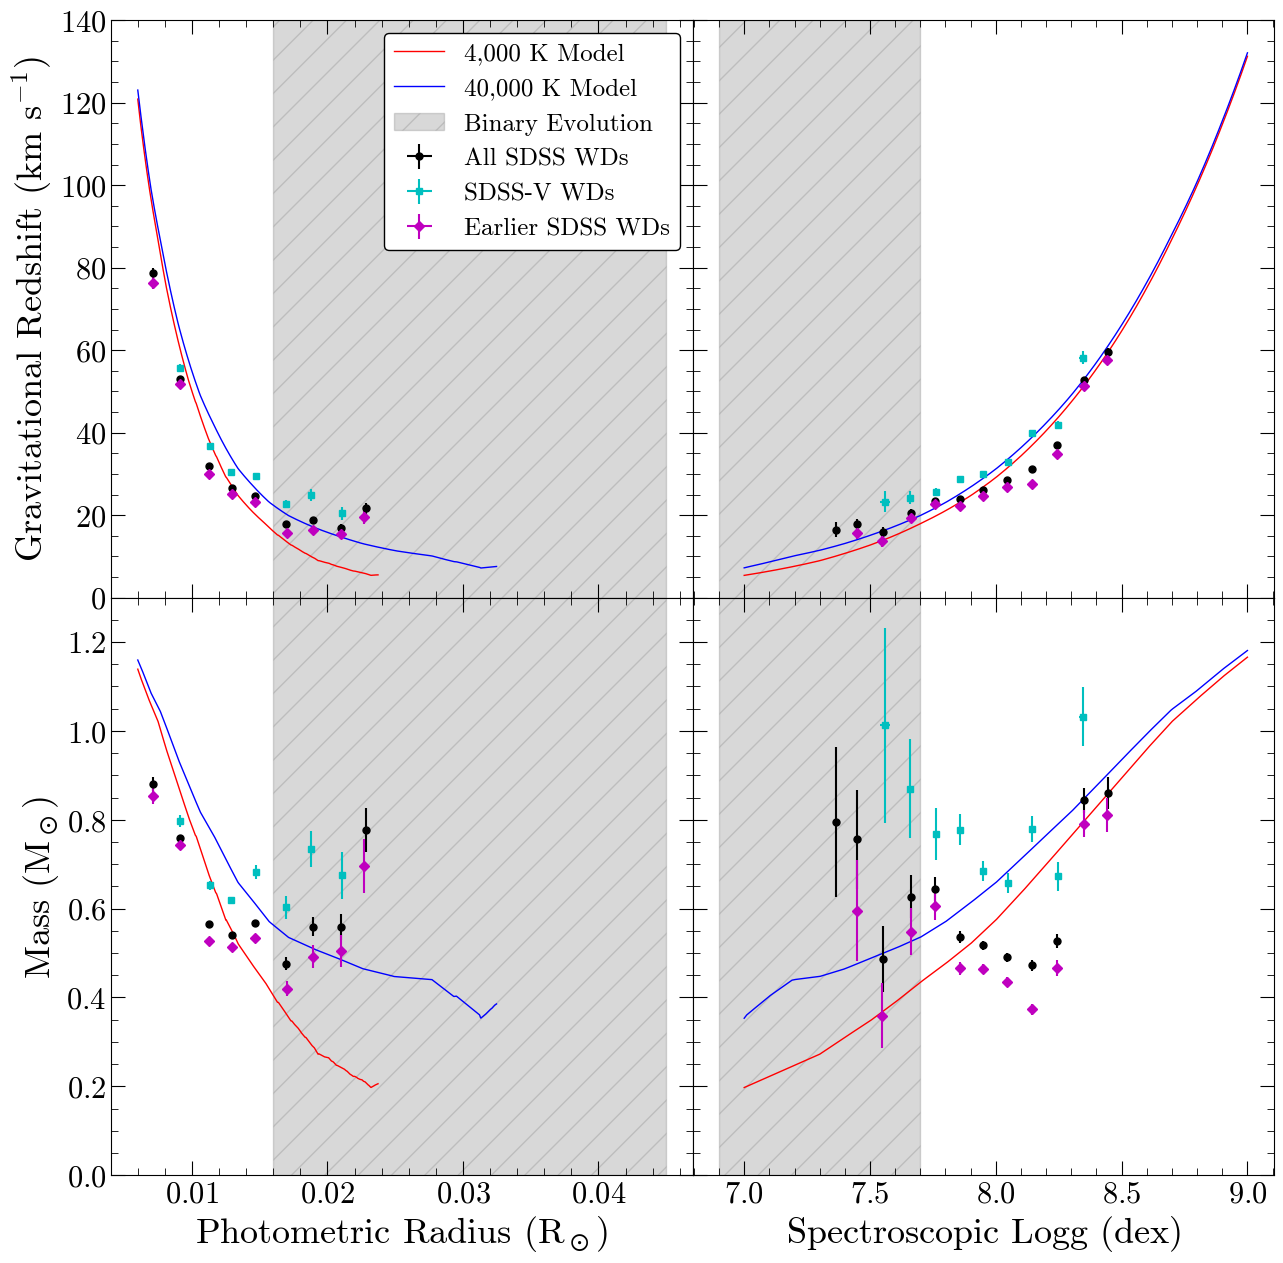

In [17]:
plot_eos(Eos_tab_rad_avg,Eos_tab_logg_avg,'LSR',50)

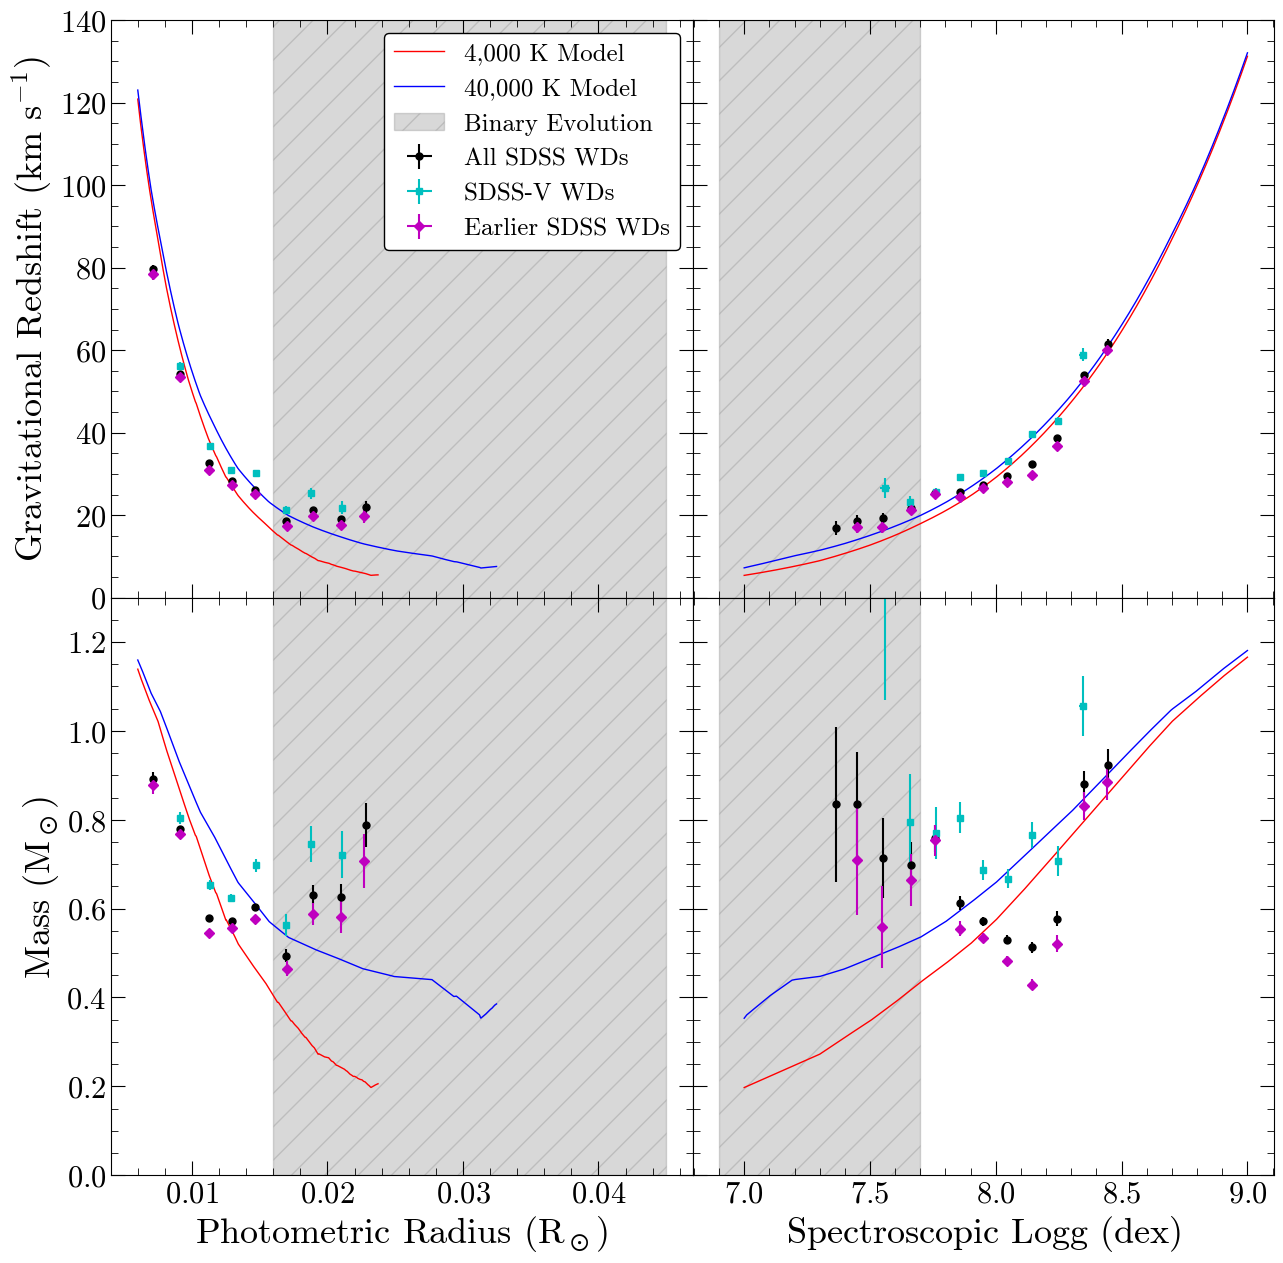

In [18]:
plot_eos(Eos_tab_rad_avg,Eos_tab_logg_avg,'asym',50)

# Repeat for data set divided into cool and warm sub samples

### Separate into cool (Teff_Phot<11,000 K) and warm samples (Teff_Phot>16,000 K)

From below, we see that the spectroscopic Teff skews slightly warmer than the photometric.

Generally, photometric Teffs are considered superior to spectroscopic so we use photometric temperatures for everything.

Text(0, 0.5, 'Counts')

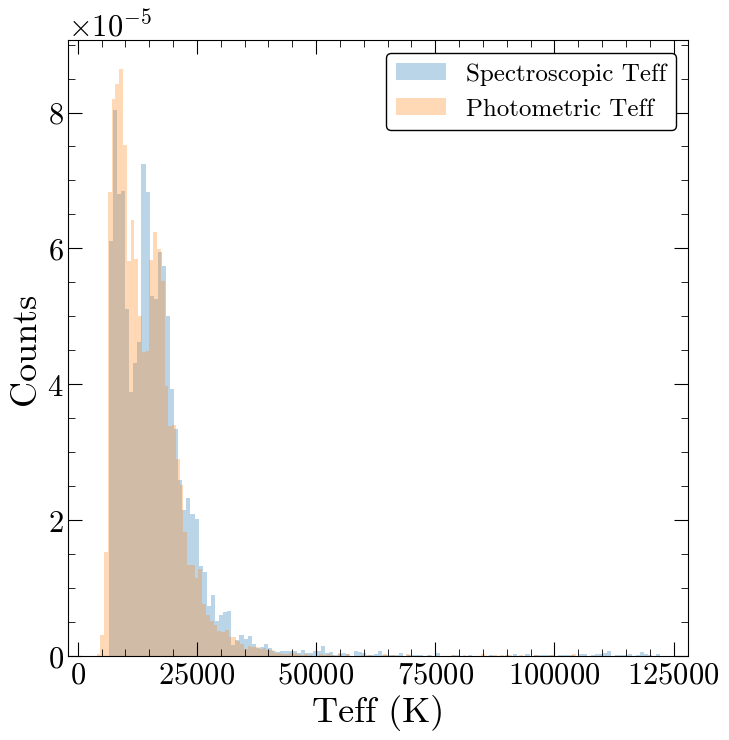

In [19]:
fig, ax1 =plt.subplots(1,1,figsize=(8,8))
ax1.hist(Eos_tab['teff_prf_coadd'],label='Spectroscopic Teff',density=True,alpha=0.3)
ax1.hist(Eos_tab['teff_phot'],label='Photometric Teff',density=True,alpha=0.3)
ax1.legend()
ax1.set_xlabel(r'Teff (K)')
ax1.set_ylabel(r'Counts')

In [20]:
cool_lim=11000
warm_lim=16000 

SDSSV_eos_tab_cool=SDSSV_eos_tab.query('teff_phot<@cool_lim')
eSDSS_eos_tab_cool=eSDSS_eos_tab.query('teff_phot<@cool_lim')
Eos_tab_cool=Eos_tab.query('teff_phot<@cool_lim')

SDSSV_eos_tab_warm=SDSSV_eos_tab.query('teff_phot>@warm_lim')
eSDSS_eos_tab_warm=eSDSS_eos_tab.query('teff_phot>@warm_lim')
Eos_tab_warm=Eos_tab.query('teff_phot>@warm_lim')

In [21]:
print('All')
print(len(Eos_tab_cool))
print(len(Eos_tab_warm))
print('')

print('SDSSV')
print(len(SDSSV_eos_tab_cool))
print(len(SDSSV_eos_tab_warm))
print('')

print('eSDSS')
print(len(eSDSS_eos_tab_cool))
print(len(eSDSS_eos_tab_warm))

print('Number WDs excluded=',len(Eos_tab)-len(Eos_tab_cool)-len(Eos_tab_warm))


All
3735
3681

SDSSV
1059
898

eSDSS
2676
2783
Number WDs excluded= 2713


In [22]:
print('95% of cool WDs are hotter than ', Eos_tab_cool['teff_phot'].quantile(.05))
print('95% of warm WDs are cooler than ', Eos_tab_warm['teff_phot'].quantile(.95))

95% of cool WDs are hotter than  6445.779986715926
95% of warm WDs are cooler than  32664.008660547144


Text(0.5, 0, 'Teff Phot')

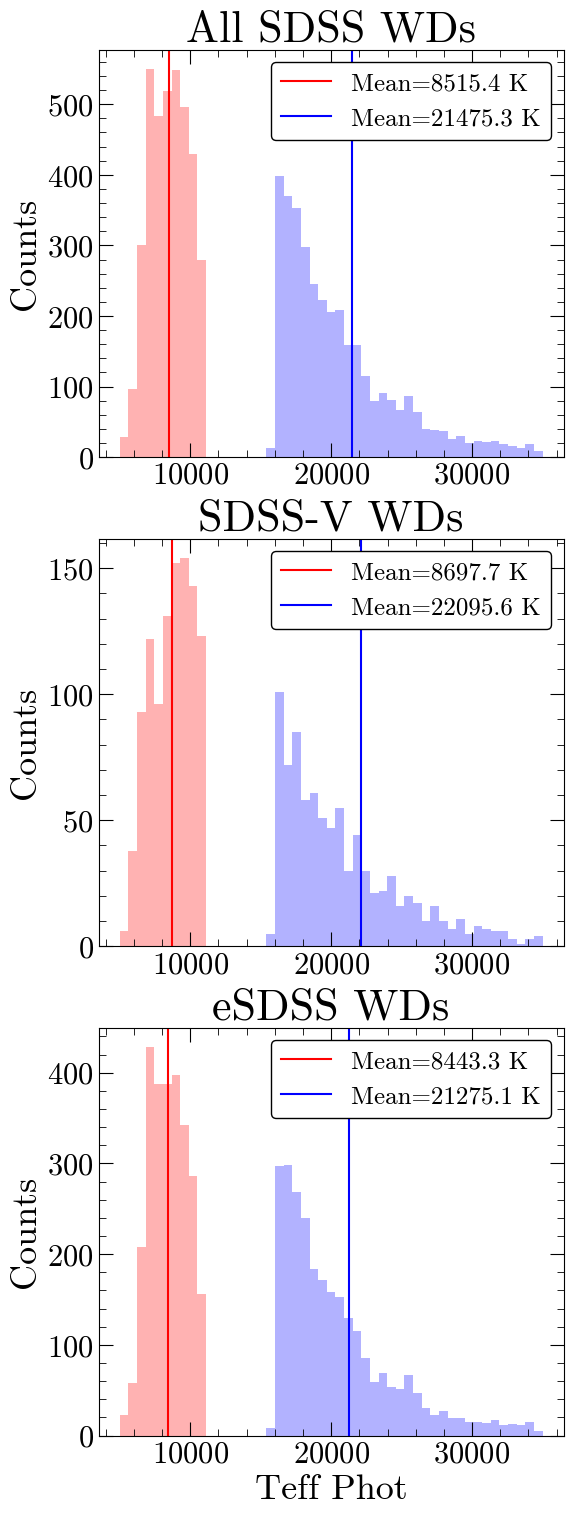

In [23]:
bins=np.linspace(5000,35000,50)
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(6,18)) 

ax1.hist(Eos_tab_cool['teff_phot'],color='red',alpha=0.3,bins=bins)
ax1.hist(Eos_tab_warm['teff_phot'],color='blue',alpha=0.3,bins=bins)
ax1.axvline(x = np.mean(Eos_tab_cool['teff_phot']), color = 'red',label='Mean='+str(np.round(np.mean(Eos_tab_cool['teff_phot']),1))+' K')
ax1.axvline(x = np.mean(Eos_tab_warm['teff_phot']), color = 'blue',label='Mean='+str(np.round(np.mean(Eos_tab_warm['teff_phot']),1))+' K')
ax1.set_ylabel('Counts')
ax1.set_title('All SDSS WDs')
ax1.legend()

ax2.hist(SDSSV_eos_tab_cool['teff_phot'],color='red',alpha=0.3,bins=bins)
ax2.hist(SDSSV_eos_tab_warm['teff_phot'],color='blue',alpha=0.3,bins=bins)
ax2.axvline(x = np.mean(SDSSV_eos_tab_cool['teff_phot']), color = 'red',label='Mean='+str(np.round(np.mean(SDSSV_eos_tab_cool['teff_phot']),1))+' K')
ax2.axvline(x = np.mean(SDSSV_eos_tab_warm['teff_phot']), color = 'blue',label='Mean='+str(np.round(np.mean(SDSSV_eos_tab_warm['teff_phot']),1))+' K')
ax2.set_ylabel('Counts')
ax2.set_title('SDSS-V WDs')
ax2.legend()

ax3.hist(eSDSS_eos_tab_cool['teff_phot'],color='red',alpha=0.3,bins=bins)
ax3.hist(eSDSS_eos_tab_warm['teff_phot'],color='blue',alpha=0.3,bins=bins)
ax3.axvline(x = np.mean(eSDSS_eos_tab_cool['teff_phot']), color = 'red',label='Mean='+str(np.round(np.mean(eSDSS_eos_tab_cool['teff_phot']),1))+' K')
ax3.axvline(x = np.mean(eSDSS_eos_tab_warm['teff_phot']), color = 'blue',label='Mean='+str(np.round(np.mean(eSDSS_eos_tab_warm['teff_phot']),1))+' K')
ax3.set_ylabel('Counts')
ax3.set_title('eSDSS WDs')
ax3.legend()
ax3.set_xlabel('Teff Phot')

### Compute averaged parameters for data binned in photometric radius

In [24]:
tmp1_LSR=weighted_avg(SDSSV_eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_SDSSV_LSR')
tmp2_LSR=weighted_avg(eSDSS_eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_eSDSS_LSR')
tmp3_LSR=weighted_avg(Eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_All_LSR')

tmp1_asym=weighted_avg(SDSSV_eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_SDSSV_asym')
tmp2_asym=weighted_avg(eSDSS_eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_eSDSS_asym')
tmp3_asym=weighted_avg(Eos_tab_cool,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_All_asym')

tmp4_LSR=weighted_avg(SDSSV_eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_SDSSV_LSR')
tmp5_LSR=weighted_avg(eSDSS_eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_eSDSS_LSR')
tmp6_LSR=weighted_avg(Eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_All_LSR')

tmp4_asym=weighted_avg(SDSSV_eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_SDSSV_asym')
tmp5_asym=weighted_avg(eSDSS_eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_eSDSS_asym')
tmp6_asym=weighted_avg(Eos_tab_warm,r_bin_nums,r_bin_ranges,r_bin_centers,'radius_bin_id','radii','radius_phot','e_radius_phot_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_All_asym')

df_array=[tmp1_LSR,tmp2_LSR,tmp3_LSR,tmp1_asym,tmp2_asym,tmp3_asym,tmp4_LSR,tmp5_LSR,tmp6_LSR,tmp4_asym,tmp5_asym,tmp6_asym] #combine all averaging results in 1 table

Teff_Eos_tab_rad_avg=combine_avg_tables(df_array,'radius_bin_id')
display(Teff_Eos_tab_rad_avg)


,radius_bin_id,Bin_range,Bin_center,mean_radii_cool_SDSSV_LSR,e_mean_radii_cool_SDSSV_LSR,mean_RVs_cool_SDSSV_LSR,e_mean_RVs_cool_SDSSV_LSR,mass_cool_SDSSV_LSR,e_mass_cool_SDSSV_LSR,num_obs_per_bin_cool_SDSSV_LSR,mean_radii_cool_eSDSS_LSR,e_mean_radii_cool_eSDSS_LSR,mean_RVs_cool_eSDSS_LSR,e_mean_RVs_cool_eSDSS_LSR,mass_cool_eSDSS_LSR,e_mass_cool_eSDSS_LSR,num_obs_per_bin_cool_eSDSS_LSR,mean_radii_cool_All_LSR,e_mean_radii_cool_All_LSR,mean_RVs_cool_All_LSR,e_mean_RVs_cool_All_LSR,mass_cool_All_LSR,e_mass_cool_All_LSR,num_obs_per_bin_cool_All_LSR,mean_radii_cool_SDSSV_asym,e_mean_radii_cool_SDSSV_asym,mean_RVs_cool_SDSSV_asym,e_mean_RVs_cool_SDSSV_asym,mass_cool_SDSSV_asym,e_mass_cool_SDSSV_asym,num_obs_per_bin_cool_SDSSV_asym,mean_radii_cool_eSDSS_asym,e_mean_radii_cool_eSDSS_asym,mean_RVs_cool_eSDSS_asym,e_mean_RVs_cool_eSDSS_asym,mass_cool_eSDSS_asym,e_mass_cool_eSDSS_asym,num_obs_per_bin_cool_eSDSS_asym,mean_radii_cool_All_asym,e_mean_radii_cool_All_asym,mean_RVs_cool_All_asym,e_mean_RVs_cool_All_asym,mass_cool_All_asym,e_mass_cool_All_asym,num_obs_per_bin_cool_All_asym,mean_radii_warm_SDSSV_LSR,e_mean_radii_warm_SDSSV_LSR,mean_RVs_warm_SDSSV_LSR,e_mean_RVs_warm_SDSSV_LSR,mass_warm_SDSSV_LSR,e_mass_warm_SDSSV_LSR,num_obs_per_bin_warm_SDSSV_LSR,mean_radii_warm_eSDSS_LSR,e_mean_radii_warm_eSDSS_LSR,mean_RVs_warm_eSDSS_LSR,e_mean_RVs_warm_eSDSS_LSR,mass_warm_eSDSS_LSR,e_mass_warm_eSDSS_LSR,num_obs_per_bin_warm_eSDSS_LSR,mean_radii_warm_All_LSR,e_mean_radii_warm_All_LSR,mean_RVs_warm_All_LSR,e_mean_RVs_warm_All_LSR,mass_warm_All_LSR,e_mass_warm_All_LSR,num_obs_per_bin_warm_All_LSR,mean_radii_warm_SDSSV_asym,e_mean_radii_warm_SDSSV_asym,mean_RVs_warm_SDSSV_asym,e_mean_RVs_warm_SDSSV_asym,mass_warm_SDSSV_asym,e_mass_warm_SDSSV_asym,num_obs_per_bin_warm_SDSSV_asym,mean_radii_warm_eSDSS_asym,e_mean_radii_warm_eSDSS_asym,mean_RVs_warm_eSDSS_asym,e_mean_RVs_warm_eSDSS_asym,mass_warm_eSDSS_asym,e_mass_warm_eSDSS_asym,num_obs_per_bin_warm_eSDSS_asym,mean_radii_warm_All_asym,e_mean_radii_warm_All_asym,mean_RVs_warm_All_asym,e_mean_RVs_warm_All_asym,mass_warm_All_asym,e_mass_warm_All_asym,num_obs_per_bin_warm_All_asym
0,0,[0. 0.002],0.001,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,[0.002 0.004],0.003,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,[0.004 0.006],0.005,0.004926,0.005725,38.101825,9.482051,0.294783,0.350389,1,0.004480,0.000989,86.588354,24.869278,0.609226,0.220670,1,0.004493,0.000974,44.255763,8.859907,0.312277,0.092164,2,0.004926,0.005725,45.990442,9.482051,0.355815,0.420017,1,0.004480,0.000989,87.080509,24.869278,0.612689,0.221137,1,0.004493,0.000974,51.205617,8.859907,0.361316,0.100238,2,0.005720,0.000903,35.700265,10.854388,0.320725,0.109880,3,0.005275,0.000245,114.126948,4.779203,0.945642,0.059141,12,0.005306,0.000236,101.391661,4.373990,0.844972,0.052414,15,0.005720,0.000903,47.025545,10.854388,0.422470,0.118147,3,0.005275,0.000245,118.207595,4.779203,0.979454,0.060316,12,0.005306,0.000236,106.648725,4.373990,0.888783,0.053834,15
3,3,[0.006 0.008],0.007,0.007510,0.000257,68.435607,3.438297,0.807187,0.049040,17,0.007540,0.000152,69.612580,2.180511,0.824390,0.030712,30,0.007532,0.000131,69.274990,1.841429,0.819533,0.026022,47,0.007510,0.000257,69.023042,3.438297,0.814115,0.049174,17,0.007540,0.000152,72.240105,2.180511,0.855506,0.031056,30,0.007532,0.000131,71.317358,1.841429,0.843694,0.026253,47,0.006953,0.000267,82.664950,4.235201,0.902754,0.057835,13,0.006988,0.000182,72.167091,3.10788

### Compute averaged parameters for data binned in spectroscopic logg

In [25]:
tmp1_LSR=weighted_avg(SDSSV_eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_SDSSV_LSR')
tmp2_LSR=weighted_avg(eSDSS_eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_eSDSS_LSR')
tmp3_LSR=weighted_avg(Eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='cool_All_LSR')

tmp1_asym=weighted_avg(SDSSV_eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_SDSSV_asym')
tmp2_asym=weighted_avg(eSDSS_eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_eSDSS_asym')
tmp3_asym=weighted_avg(Eos_tab_cool,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='cool_All_asym')

tmp4_LSR=weighted_avg(SDSSV_eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_SDSSV_LSR')
tmp5_LSR=weighted_avg(eSDSS_eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_eSDSS_LSR')
tmp6_LSR=weighted_avg(Eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_lsr','e_rv_corv_coadd_full',extra_name='warm_All_LSR')

tmp4_asym=weighted_avg(SDSSV_eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_SDSSV_asym')
tmp5_asym=weighted_avg(eSDSS_eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_eSDSS_asym')
tmp6_asym=weighted_avg(Eos_tab_warm,g_bin_nums,g_bin_ranges,g_bin_centers,'logg_bin_id','loggs','logg_prf_coadd','e_logg_prf_coadd_full','rv_corv_asym_corr','e_rv_corv_coadd_full',extra_name='warm_All_asym')


df_array=[tmp1_LSR,tmp2_LSR,tmp3_LSR,tmp1_asym,tmp2_asym,tmp3_asym,tmp4_LSR,tmp5_LSR,tmp6_LSR,tmp4_asym,tmp5_asym,
          tmp6_asym]

#combine all averaging results in 1 table
Teff_Eos_tab_logg_avg=combine_avg_tables(df_array,'logg_bin_id')

display(Teff_Eos_tab_logg_avg)


,logg_bin_id,Bin_range,Bin_center,mean_loggs_cool_SDSSV_LSR,e_mean_loggs_cool_SDSSV_LSR,mean_RVs_cool_SDSSV_LSR,e_mean_RVs_cool_SDSSV_LSR,mass_cool_SDSSV_LSR,e_mass_cool_SDSSV_LSR,num_obs_per_bin_cool_SDSSV_LSR,mean_loggs_cool_eSDSS_LSR,e_mean_loggs_cool_eSDSS_LSR,mean_RVs_cool_eSDSS_LSR,e_mean_RVs_cool_eSDSS_LSR,mass_cool_eSDSS_LSR,e_mass_cool_eSDSS_LSR,num_obs_per_bin_cool_eSDSS_LSR,mean_loggs_cool_All_LSR,e_mean_loggs_cool_All_LSR,mean_RVs_cool_All_LSR,e_mean_RVs_cool_All_LSR,mass_cool_All_LSR,e_mass_cool_All_LSR,num_obs_per_bin_cool_All_LSR,mean_loggs_cool_SDSSV_asym,e_mean_loggs_cool_SDSSV_asym,mean_RVs_cool_SDSSV_asym,e_mean_RVs_cool_SDSSV_asym,mass_cool_SDSSV_asym,e_mass_cool_SDSSV_asym,num_obs_per_bin_cool_SDSSV_asym,mean_loggs_cool_eSDSS_asym,e_mean_loggs_cool_eSDSS_asym,mean_RVs_cool_eSDSS_asym,e_mean_RVs_cool_eSDSS_asym,mass_cool_eSDSS_asym,e_mass_cool_eSDSS_asym,num_obs_per_bin_cool_eSDSS_asym,mean_loggs_cool_All_asym,e_mean_loggs_cool_All_asym,mean_RVs_cool_All_asym,e_mean_RVs_cool_All_asym,mass_cool_All_asym,e_mass_cool_All_asym,num_obs_per_bin_cool_All_asym,mean_loggs_warm_SDSSV_LSR,e_mean_loggs_warm_SDSSV_LSR,mean_RVs_warm_SDSSV_LSR,e_mean_RVs_warm_SDSSV_LSR,mass_warm_SDSSV_LSR,e_mass_warm_SDSSV_LSR,num_obs_per_bin_warm_SDSSV_LSR,mean_loggs_warm_eSDSS_LSR,e_mean_loggs_warm_eSDSS_LSR,mean_RVs_warm_eSDSS_LSR,e_mean_RVs_warm_eSDSS_LSR,mass_warm_eSDSS_LSR,e_mass_warm_eSDSS_LSR,num_obs_per_bin_warm_eSDSS_LSR,mean_loggs_warm_All_LSR,e_mean_loggs_warm_All_LSR,mean_RVs_warm_All_LSR,e_mean_RVs_warm_All_LSR,mass_warm_All_LSR,e_mass_warm_All_LSR,num_obs_per_bin_warm_All_LSR,mean_loggs_warm_SDSSV_asym,e_mean_loggs_warm_SDSSV_asym,mean_RVs_warm_SDSSV_asym,e_mean_RVs_warm_SDSSV_asym,mass_warm_SDSSV_asym,e_mass_warm_SDSSV_asym,num_obs_per_bin_warm_SDSSV_asym,mean_loggs_warm_eSDSS_asym,e_mean_loggs_warm_eSDSS_asym,mean_RVs_warm_eSDSS_asym,e_mean_RVs_warm_eSDSS_asym,mass_warm_eSDSS_asym,e_mass_warm_eSDSS_asym,num_obs_per_bin_warm_eSDSS_asym,mean_loggs_warm_All_asym,e_mean_loggs_warm_All_asym,mean_RVs_warm_All_asym,e_mean_RVs_warm_All_asym,mass_warm_All_asym,e_mass_warm_All_asym,num_obs_per_bin_warm_All_asym
0,0,[7. 7.1],7.05,7.046890,0.072189,-37.023722,16.327874,8.330503,-7.477028,2,7.042349,0.023894,34.749058,4.782604,7.415453,2.081589,16,7.042798,0.022684,29.077781,4.589762,5.187114,1.659774,18,7.046890,0.072189,-43.582299,16.327874,11.543336,-8.859567,2,7.042349,0.023894,36.007243,4.782604,7.962168,2.160010,16,7.042798,0.022684,29.718308,4.589762,5.418155,1.697342,18,NaN,NaN,NaN,NaN,NaN,NaN,0,7.069357,0.053242,28.890662,14.195046,4.816807,4.770043,3,7.069357,0.053242,28.890662,14.195046,4.816807,4.770043,3,NaN,NaN,NaN,NaN,NaN,NaN,0,7.069357,0.053242,28.262884,14.195046,4.609748,4.664855,3,7.069357,0.053242,28.262884,14.195046,4.609748,4.664855,3
1,1,[7.1 7.2],7.15,7.143679,0.039325,0.417971,6.232006,0.000850,0.025335,9,7.159544,0.027257,29.045647,5.903681,3.955661,1.627070,23,7.154395,0.022402,15.505750,4.285905,1.140751,0.633364,32,7.143679,0.039325,7.222373,6.232006,0.253677,0.438386,9,7.159544,0.027257,27.983198,5.903681,3.671568,1.566243,23,7.154395,0.022402,18.164048,4.285905,1.565419,0.743138,32,NaN,NaN,NaN,NaN,NaN,NaN,0,7.167360,0.128095,76.249200,27.375608,26.773891,20.783852,1,7.167360,0.128095,76.249200,27.375608,26.773891,20.783852,1,NaN,NaN,NaN,NaN,NaN,NaN,0,7.167360,0.128095,85.739658,27.375608,33.853564,23.812642,1,7.167360,0.128095,85.739658,27.375608,33.853564,23.812642,1
2,2,[7.2 7.3],7.25,7.236418,0.075844,66.451901,12.158830,17.345943,7.033416,4,7.236460,0.043153,35.211475,5.340846,4.869775,1.554515,7,7.236450,0.037507,40.264281,4.889896,6.367820,1.641542,11,7.236418,0.075844,77.199010,12.158830,23.410277,8.431703,4,7.236460,0.043153,37.601101,5.340846,5.553178,1.671260,7,7.236450,0.037507,44.005640,4.889896,7.606197,1.813548,11,7.227840,0.107686,61.786746,23.874528,15.295073,12.413612,1,7.250670,0.021850,10.712543,2.624658,0.436230,0.214884,14,7.249767,0.021414,11.322445,2.608940,0.488331,0.226329,15,7.2

### Check for negative errors

In [26]:
tables=[Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg]
for table in tables:
    columns=table.columns.to_list()[3:]
    for col in columns:
        negatives=table.query(col+'<0')[col].index.to_list()
        if len(negatives)>0:
            table[col].loc[negatives]=np.nan

### Save the tables

In [27]:
#save the tables
Teff_Eos_tab_rad_avg.to_csv('csv/Teff_Eos_tab_rad_avg.csv',index=False)
Teff_Eos_tab_logg_avg.to_csv('csv/Teff_Eos_tab_logg_avg.csv',index=False)


### Plots

In [28]:
def plot_teff_eos(table_phot,table_spec,SDSSType,key,num_obs_per_bin=None):
    #SDSSType='SDSSV','eSDSS', or 'All'
    #key = 'LSR' for LSR-corrected RVs
    #key = 'asym' for LSR-corrected+Asymmetric drift-corrected RVs
    
    fig, ((ax1,ax2),(ax4,ax5)) =plt.subplots(2,2,figsize=(15,15))
    plt.style.use('stefan.mplstyle')
    
    #crop all the tables to have only bins with num_obs_per_bin>threshold
    table_phot_cool=table_phot.query('num_obs_per_bin_cool_'+SDSSType+'_'+key+'>@num_obs_per_bin')
    table_phot_warm=table_phot.query('num_obs_per_bin_warm_'+SDSSType+'_'+key+'>@num_obs_per_bin')
    
    table_spec_cool=table_spec.query('num_obs_per_bin_cool_'+SDSSType+'_'+key+'>@num_obs_per_bin')
    table_spec_warm=table_spec.query('num_obs_per_bin_warm_'+SDSSType+'_'+key+'>@num_obs_per_bin')
    
    tables=[table_phot_cool,table_phot_warm,table_spec_cool,table_spec_warm]
    for table in tables:
        #reset the indices
        indices=np.arange(0,len(table))
        table.set_index(indices,inplace=True)

    #get theoretical R-vg relation
    theo_radii = np.linspace(0.006,0.04, 1000)
    theo_vg_r_lowT = theo_vg_from_r_teff(theo_radii, 4000)
    theo_vg_r_highT = theo_vg_from_r_teff(theo_radii, 40000)
    #plot theoretical R-vg relation
    ax1.plot(theo_radii, theo_vg_r_lowT, 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax1.plot(theo_radii, theo_vg_r_highT, 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax1.errorbar(table_phot_cool['mean_radii_cool_'+SDSSType+'_'+key],table_phot_cool['mean_RVs_cool_'+SDSSType+'_'+key],
                 xerr=table_phot_cool['e_mean_radii_cool_'+SDSSType+'_'+key],yerr=table_phot_cool['e_mean_RVs_cool_'+SDSSType+'_'+key],fmt='ro',label='Cool WDs')
    ax1.errorbar(table_phot_warm['mean_radii_warm_'+SDSSType+'_'+key],table_phot_warm['mean_RVs_warm_'+SDSSType+'_'+key],
                 xerr=table_phot_warm['e_mean_radii_warm_'+SDSSType+'_'+key],yerr=table_phot_warm['e_mean_RVs_warm_'+SDSSType+'_'+key],fmt='bo',label='Warm WDs')
    #exclude Binary Evolution
    ax1.axvspan(0.016, 0.045, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax1.legend()
    ax1.set_ylabel('Gravitational Redshift ($km$ $s^{-1}$)')
    
    #get theoretical logg-vg relation
    theo_loggs = np.linspace(7,9, 1000)
    theo_vg_logg_lowT = theo_vg_from_logg_teff(theo_loggs, 4000)
    theo_vg_logg_highT = theo_vg_from_logg_teff(theo_loggs, 40000)
    #plot theoretical logg-vg relation
    ax2.plot(theo_loggs, theo_vg_logg_lowT, 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax2.plot(theo_loggs, theo_vg_logg_highT, 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax2.errorbar(table_spec_cool['mean_loggs_cool_'+SDSSType+'_'+key],table_spec_cool['mean_RVs_cool_'+SDSSType+'_'+key],
                 xerr=table_spec_cool['e_mean_loggs_cool_'+SDSSType+'_'+key],yerr=table_spec_cool['e_mean_RVs_cool_'+SDSSType+'_'+key],fmt='ro',label='Cool WDs')
    ax2.errorbar(table_spec_warm['mean_loggs_warm_'+SDSSType+'_'+key],table_spec_warm['mean_RVs_warm_'+SDSSType+'_'+key],
                 xerr=table_spec_warm['e_mean_loggs_warm_'+SDSSType+'_'+key],yerr=table_spec_warm['e_mean_RVs_warm_'+SDSSType+'_'+key],fmt='bo',label='Warm WDs')
    #exclude Binary Evolution
    ax2.axvspan(6.9, 7.7, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    
    #plot theoretical M-R relation
    ax4.plot(theo_radii, theo_m_from_vg_r(theo_vg_r_lowT, theo_radii), 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax4.plot(theo_radii, theo_m_from_vg_r(theo_vg_r_highT, theo_radii), 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax4.errorbar(table_phot_cool['mean_radii_cool_'+SDSSType+'_'+key],table_phot_cool['mass_cool_'+SDSSType+'_'+key],
                 xerr=table_phot_cool['e_mean_radii_cool_'+SDSSType+'_'+key],yerr=table_phot_cool['e_mass_cool_'+SDSSType+'_'+key],fmt='ro',label='Cool WDs')
    ax4.errorbar(table_phot_warm['mean_radii_warm_'+SDSSType+'_'+key],table_phot_warm['mass_warm_'+SDSSType+'_'+key],
                 xerr=table_phot_warm['e_mean_radii_warm_'+SDSSType+'_'+key],yerr=table_phot_warm['e_mass_warm_'+SDSSType+'_'+key],fmt='bo',label='Warm WDs')
    #exclude Binary Evolution
    ax4.axvspan(0.016, 0.045, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax4.set_xlabel('Photometric Radius ($R_\odot$)')
    ax4.set_ylabel('Mass ($M_\odot$)')
    
    #plot theoretical M-logg relation
    ax5.plot(theo_loggs, theo_m_from_vg_logg(theo_vg_logg_lowT, theo_loggs), 'red', linestyle = '-', label = '4,000 K Model', linewidth = 1)
    ax5.plot(theo_loggs, theo_m_from_vg_logg(theo_vg_logg_highT, theo_loggs), 'blue', label = '40,000 K Model', linewidth = 1)
    #plot data
    ax5.errorbar(table_spec_cool['mean_loggs_cool_'+SDSSType+'_'+key],table_spec_cool['mass_cool_'+SDSSType+'_'+key],
                 xerr=table_spec_cool['e_mean_loggs_cool_'+SDSSType+'_'+key],yerr=table_spec_cool['e_mass_cool_'+SDSSType+'_'+key],fmt='ro',label='Cool WDs')
    ax5.errorbar(table_spec_warm['mean_loggs_warm_'+SDSSType+'_'+key],table_spec_warm['mass_warm_'+SDSSType+'_'+key],
                 xerr=table_spec_warm['e_mean_loggs_warm_'+SDSSType+'_'+key],yerr=table_spec_warm['e_mass_warm_'+SDSSType+'_'+key],fmt='bo',label='Warm WDs')
    #exclude Binary Evolution
    ax5.axvspan(6.9, 7.7, hatch ='/', color = 'grey', alpha = 0.3,label='Binary Evolution')
    ax5.set_xlabel('Spectroscopic Logg ($dex$)')
    
    #make y limits consistent
    ax1.set_ylim(0,140)
    ax2.set_ylim(0,140)
    #hide tick labels
    ax2.yaxis.set_ticklabels([])
    
    #make y limits consistent
    ax4.set_ylim(0,1.3)
    ax5.set_ylim(0,1.3)
    #hide tick labels
    ax5.yaxis.set_ticklabels([])
    
    #hide xtick labels
    ax1.xaxis.set_ticklabels([])
    ax2.xaxis.set_ticklabels([])
    
    plt.subplots_adjust(hspace=0,wspace=0)
    
    if SDSSType=='All':
        fig.suptitle("All SDSS WDs",fontsize=40,y=0.93)
    if SDSSType=='SDSSV':
        fig.suptitle("SDSS-V WDs",fontsize=40,y=0.93)
    if SDSSType=='eSDSS':
        fig.suptitle("Earlier SDSS WDs",fontsize=40,y=0.93)
        

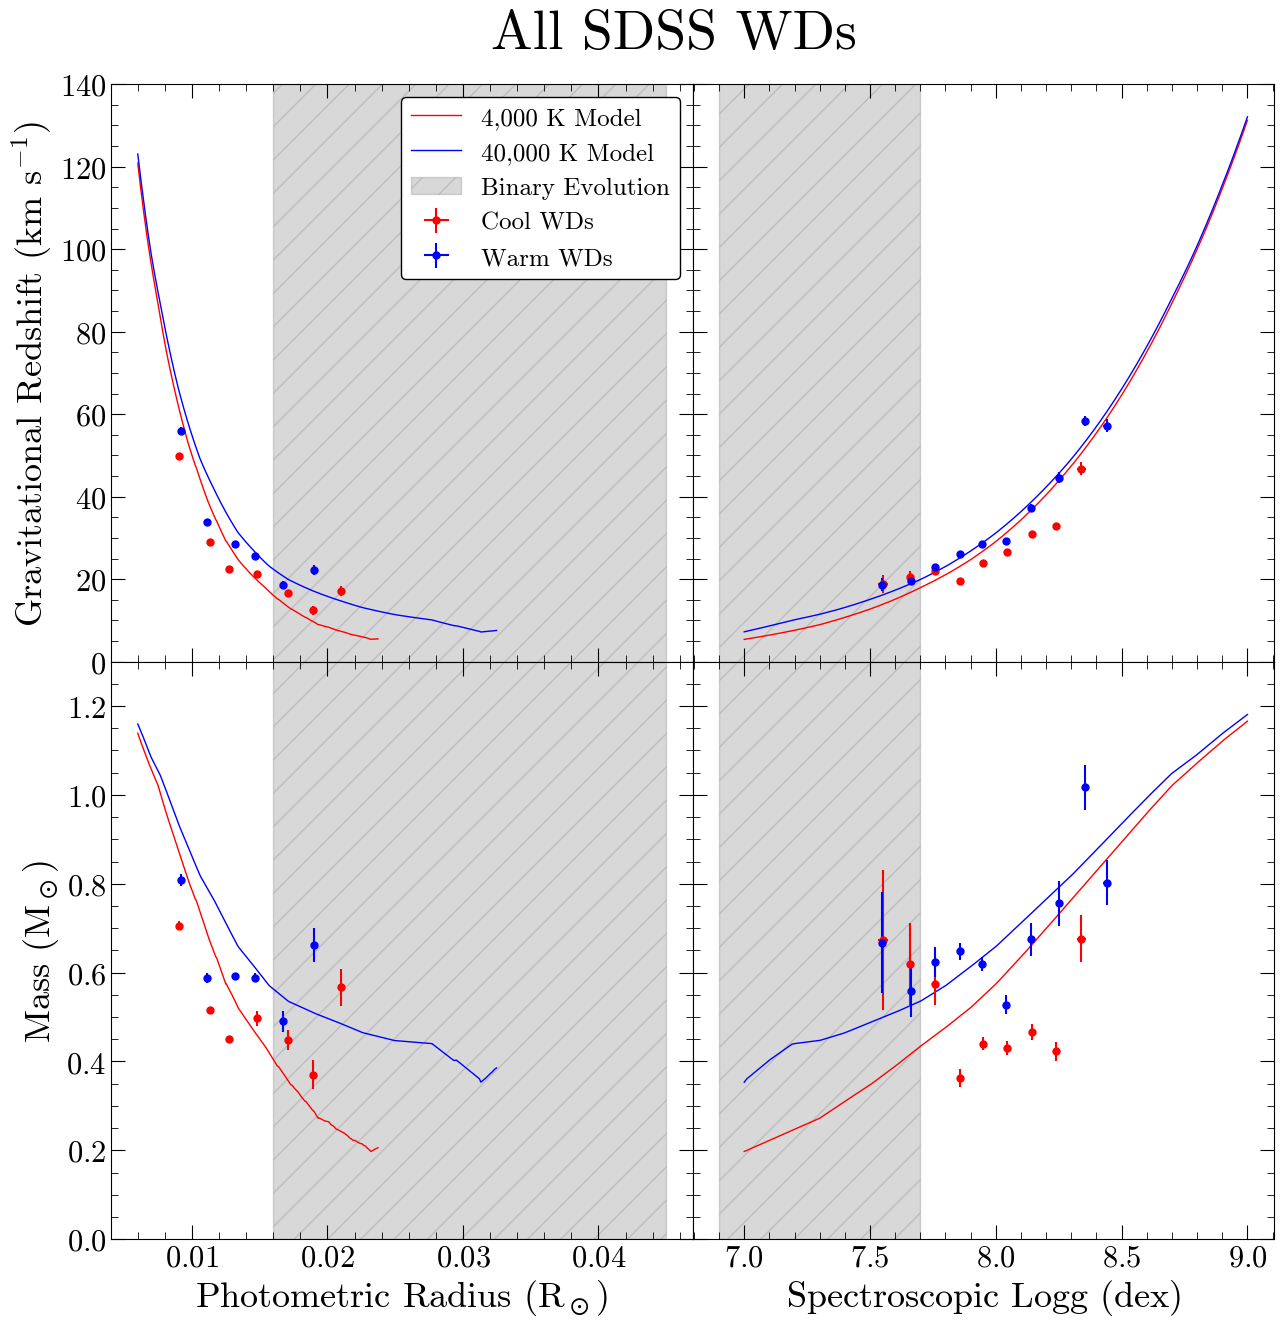

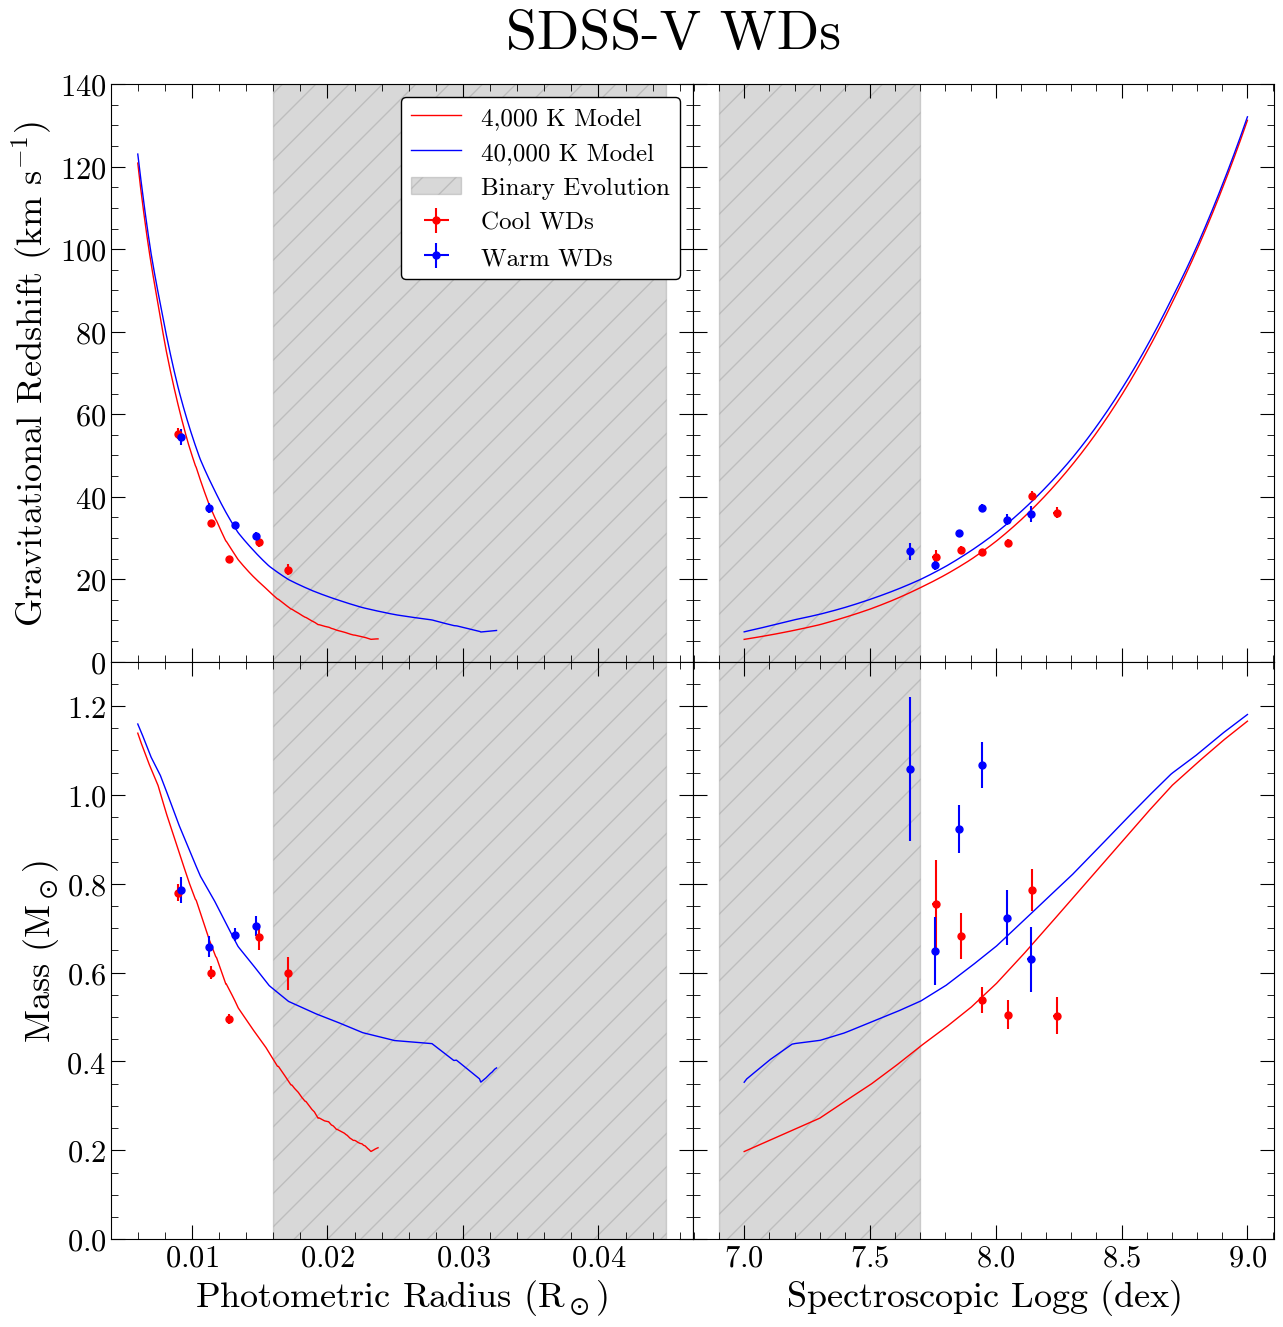

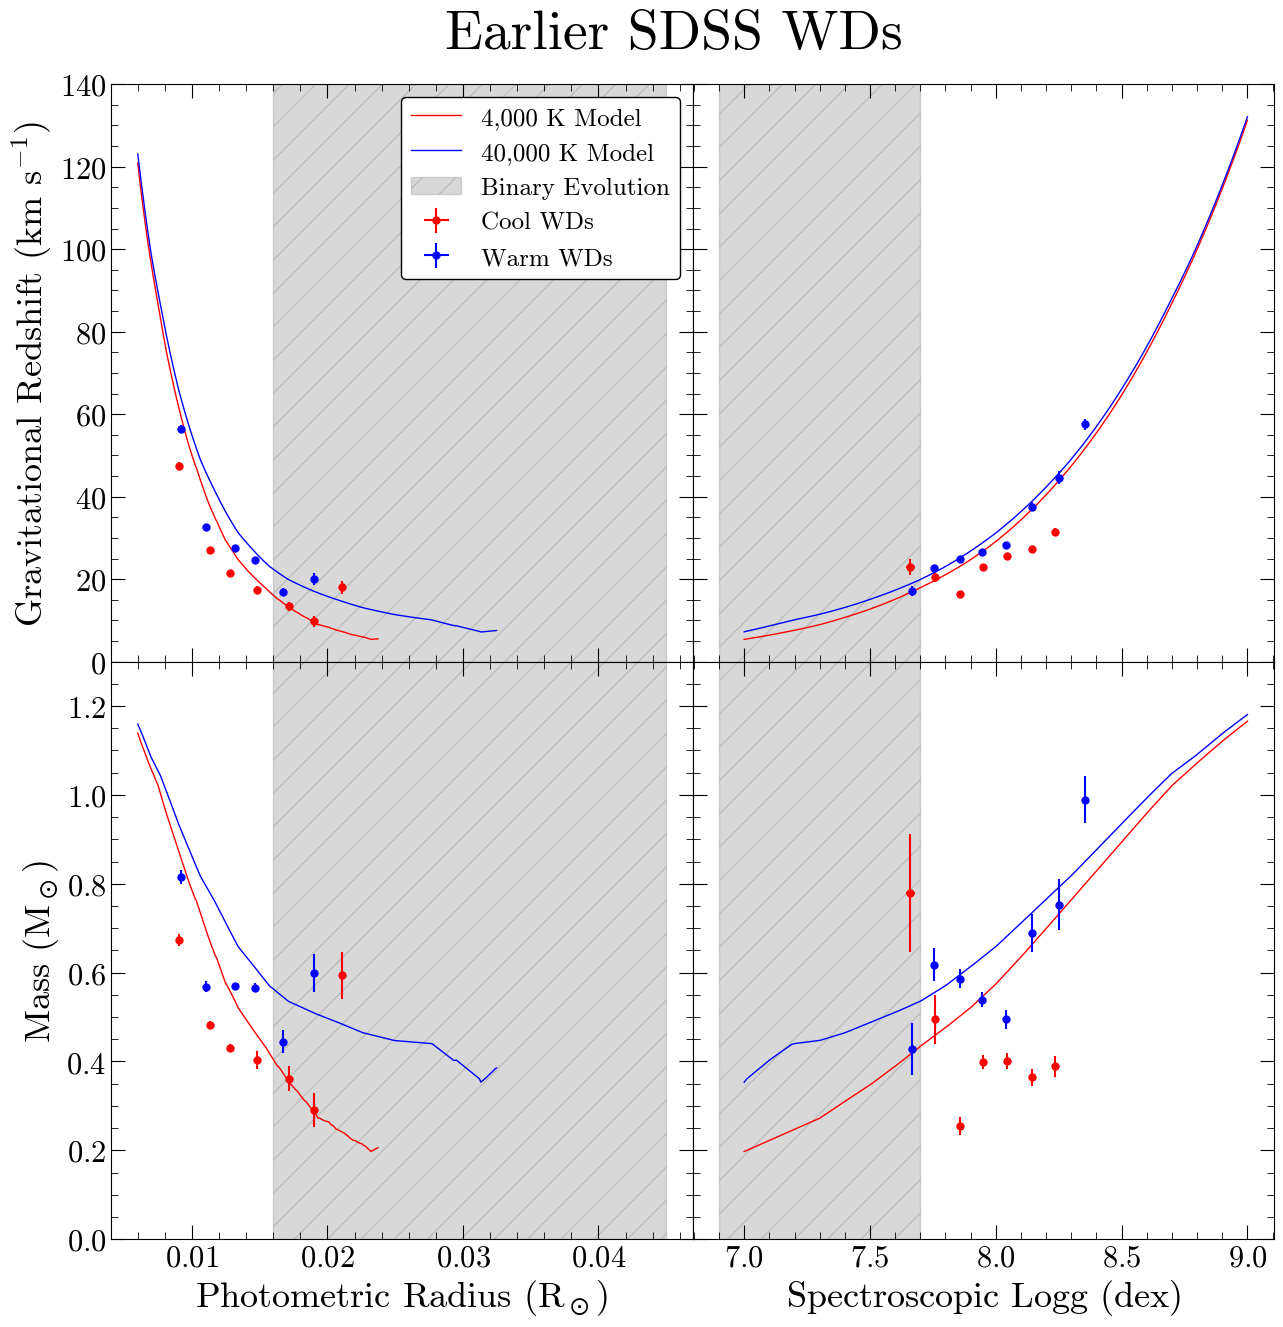

In [29]:
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'All','LSR',50)
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'SDSSV','LSR',50)
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'eSDSS','LSR',50)

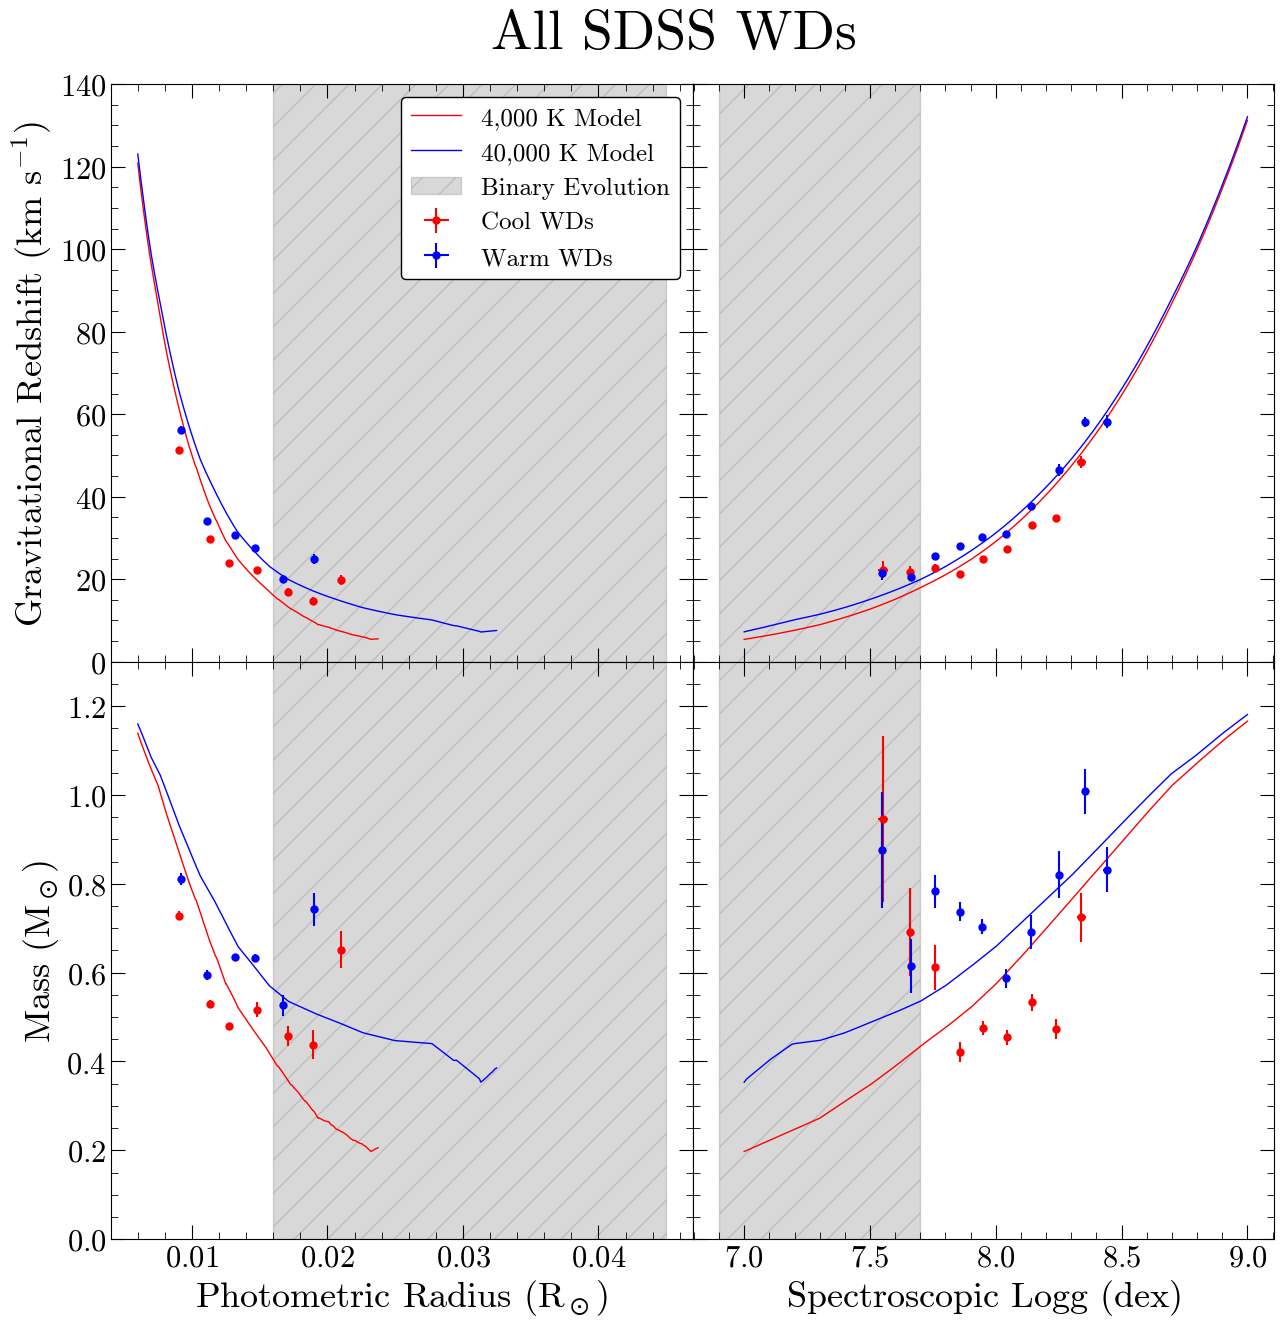

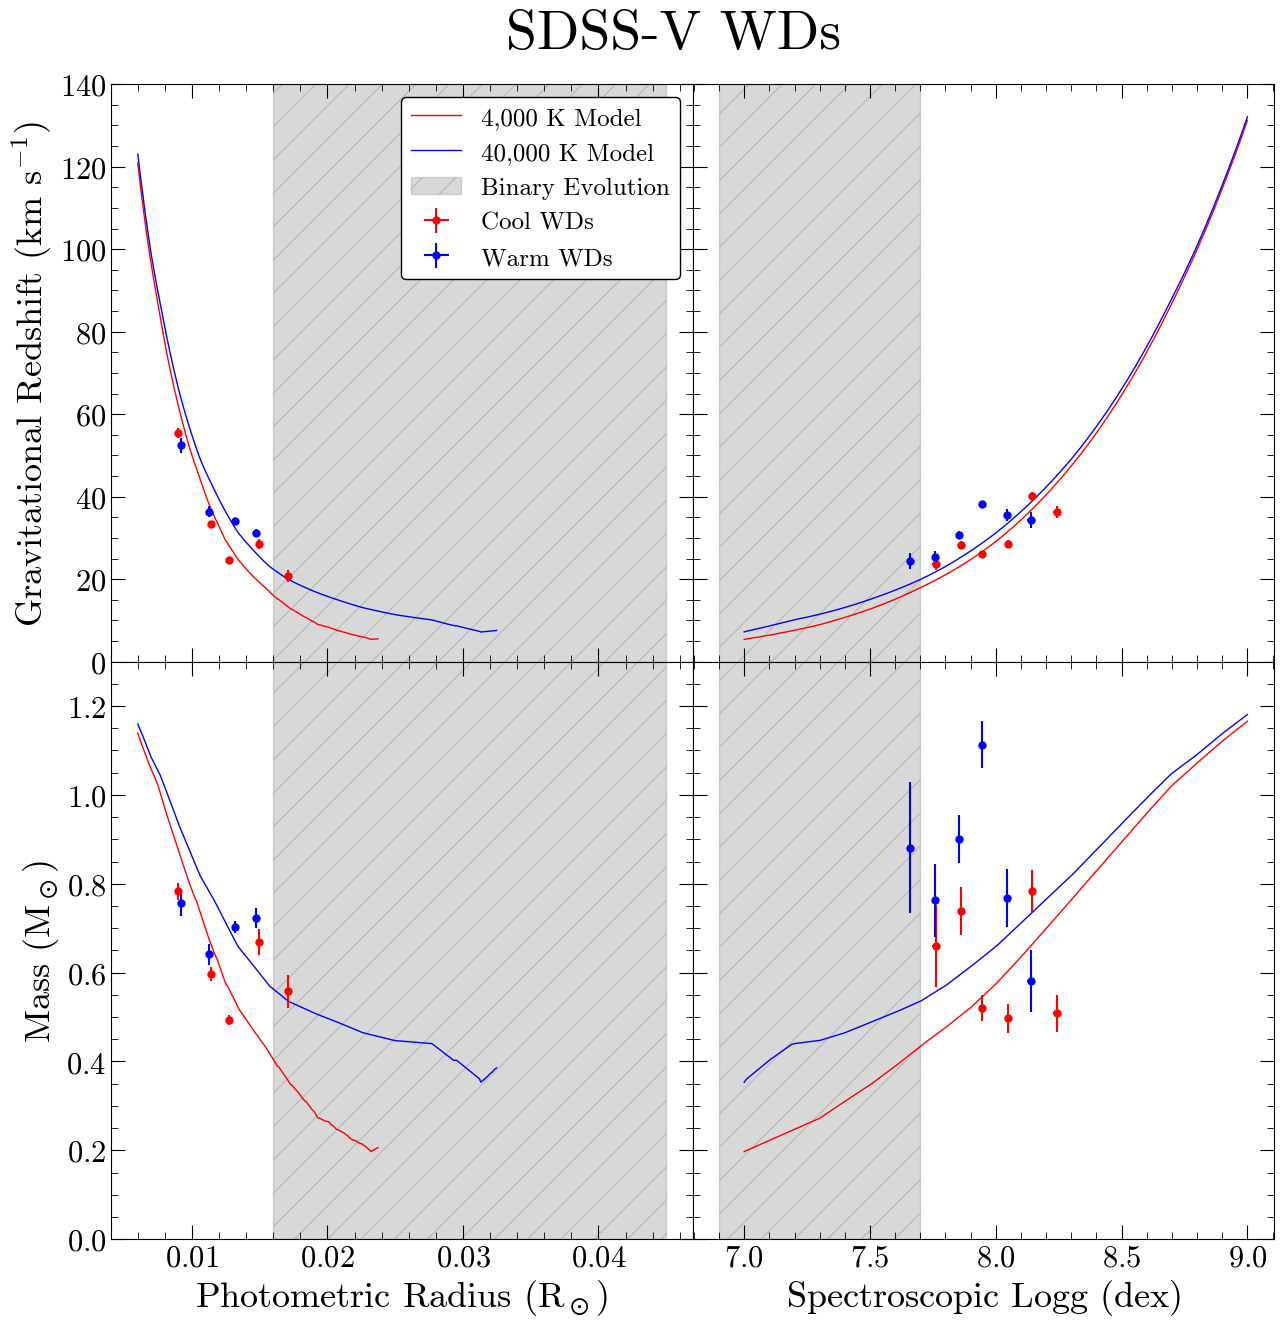

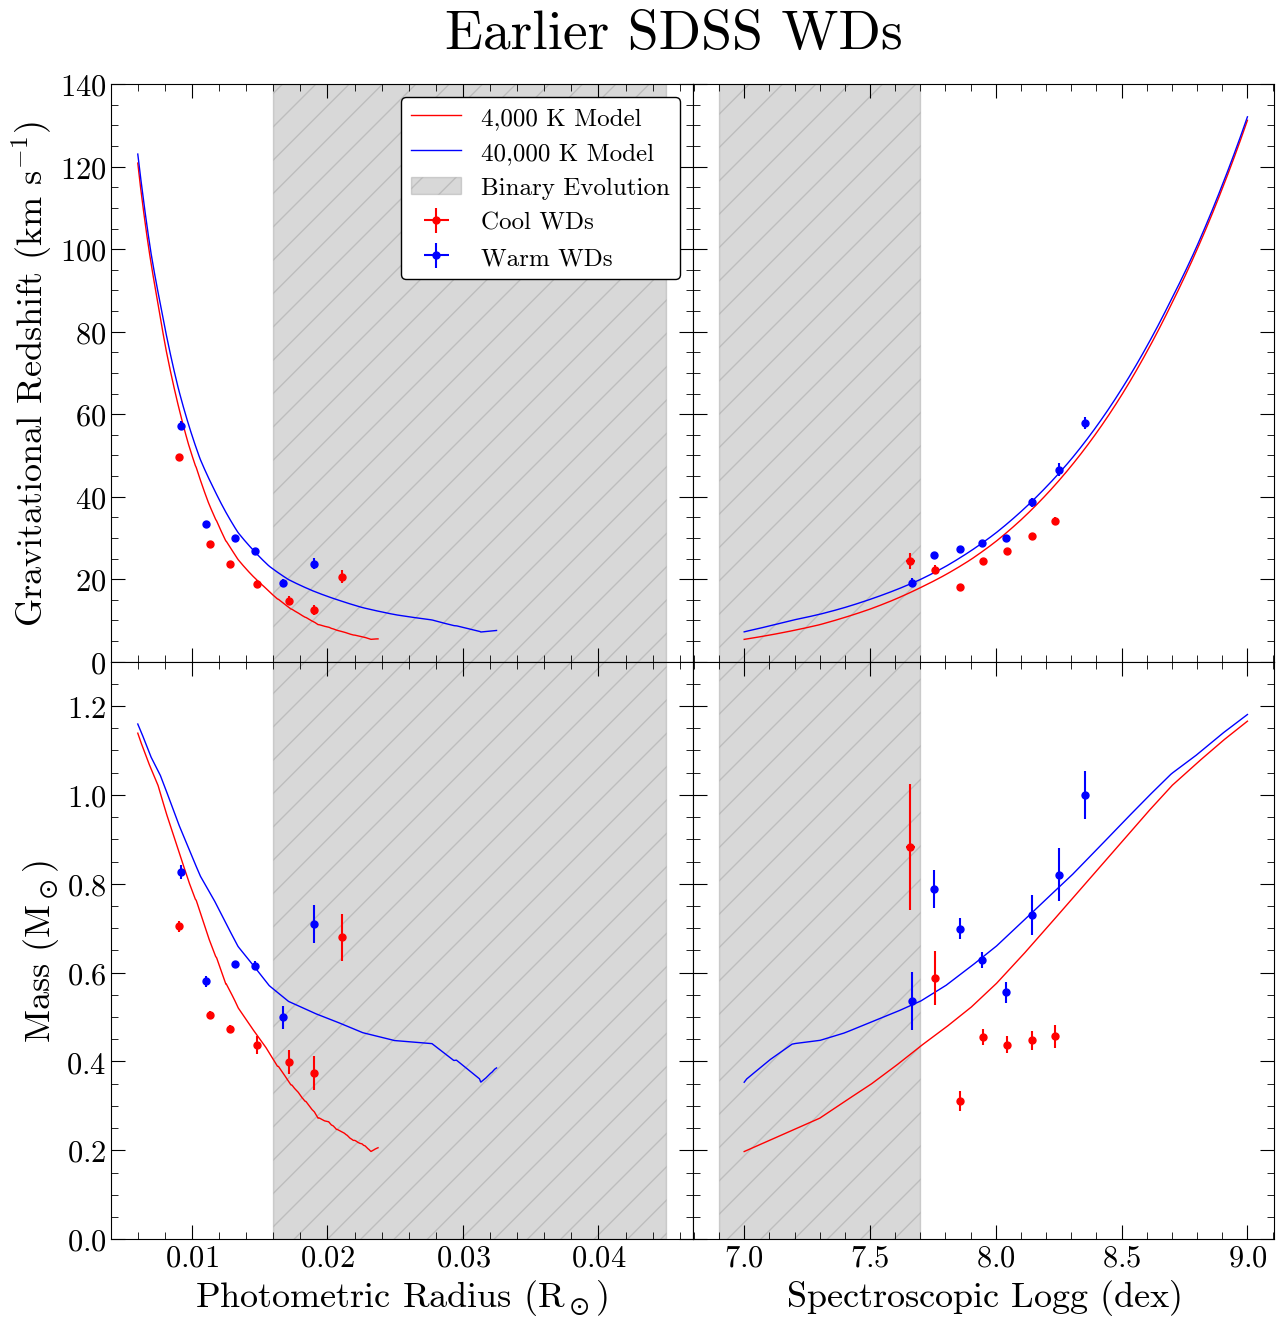

In [30]:
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'All','asym',50)
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'SDSSV','asym',50)
plot_teff_eos(Teff_Eos_tab_rad_avg,Teff_Eos_tab_logg_avg,'eSDSS','asym',50)